**Table of contents**<a id='toc0_'></a>    
<!-- - [Load Ticker Pair list](#toc1_1_1_)    
    - [Config Data From Files](#toc1_1_2_)    
    - [Load and Merge Data for Pair](#toc1_1_3_)    
    - [calculate spread](#toc1_1_4_)    
    - [Create Target](#toc1_1_5_)    
  - [Dataset Setup](#toc1_2_)    
    - [Train regression again with low importance columns removed](#toc1_2_1_)     -->
- [General Setup](#toc2_)    
    - [Benchmark Gradient Boosting Regressor Model](#toc2_1_1_)    
    - [LSTM and BiLSTM](#toc2_1_2_)    
- [Hyperparameter Tuning of LSTM Model with Keras Tuner](#toc3_)    
  - [hyper param tuning](#toc3_1_)    
    - [Run with best over all pairs](#toc3_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [95]:
import sys 
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('./../.templates/custom_onedark.mplstyle')

In [96]:
data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

### <a id='toc1_1_1_'></a>[Load Ticker Pair list](#toc0_)

In [97]:
import glob

tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
tickers_list
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values

unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

### <a id='toc1_1_2_'></a>[Config Data From Files](#toc0_)

In [98]:
ticker = 'AAPL'

price_history = pd.read_csv(price_history_dir + f'{ticker}.csv')
sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv')
ti = pd.read_csv(ti_dir + f'{ticker}.csv')

data = {}


class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)
    

In [99]:
display(DATA.AAPL.history.head(2))
display(DATA.AAPL.sentiment.head(2))
display(DATA.AAPL.ti.head(2))



,High,Low,Open,Volume,Adj Close
Date,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01


,news_pos_sentiment_count,news_sentiment_daily_avg,twitter_pos_sentiment_count
Date,,,
2021-01-01,11.0,0.0109,15
2021-01-04,3.0,-0.0008,6


,High,Low,Open,Volume,Adj Close,P,R1,R2,R3,S1,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,133.6116,126.76,133.52,143301887.0,129.41,129.927200,132.544511,134.161489,136.778800,127.309889,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,129.410000,0.00000,0.0000,0.00000
2021-01-05,131.7400,128.43,128.89,97664898.0,131.01,130.393333,131.657753,132.438913,133.703333,129.128913,...,0.098538,0.019708,0.078831,-2.60186,-0.520372,-2.081488,130.210469,1.23638,1.2288,1.23638


In [14]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df


### <a id='toc1_1_3_'></a>[Load and Merge Data for Pair](#toc0_)
change PAIR_IDX to the pair you want to analyze

In [15]:
PAIR_IDX = 0

pair = pairs[PAIR_IDX]

print(pair)

ADD_SENTIMENT_MA = True

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge(
    data[pair[0]].sentiment,
    data[pair[1]].sentiment,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(
        pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns
    )

# Join Technical Indicators
pair_ti_df = pd.merge(
    data[pair[0]].ti,
    data[pair[1]].ti,
    left_index=True,
    right_index=True,
    suffixes=("_S1", "_S2"),
)

pair_df = pd.merge(
    pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left"
)

print(pair_df.shape, pair_df.shape[0] * pair_df.shape[1])
pair_df

['GS' 'BLK']
(815, 280) 228200


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,twitter_pos_sentiment_count_S1_ma40,news_sentiment_daily_avg_S2_ma40,twitter_pos_sentiment_count_S2_ma40,news_pos_sentiment_count_S2_ma40,news_pos_sentiment_count_S1_ma80,news_sentiment_daily_avg_S1_ma80,twitter_pos_sentiment_count_S1_ma80,news_sentiment_daily_avg_S2_ma80,twitter_pos_sentiment_count_S2_ma80,news_pos_sentiment_count_S2_ma80
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,13.775,-0.000575,36.000,0.900,2.4125,0.017359,11.6500,-0.011185,27.0875,1.1750
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,13.850,-0.000875,35.100,0.850,2.4000,0.017306,11.8000,-0.011215,27.2625,1.1625
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,14.050,-0.000768,35.025,0.900,2.3875,0.018410,11.9875,-0.011123,27.3625,1.1875



### <a id='toc1_1_4_'></a>[calculate spread](#toc0_)


<Axes: title={'center': 'Spread'}, xlabel='Date'>

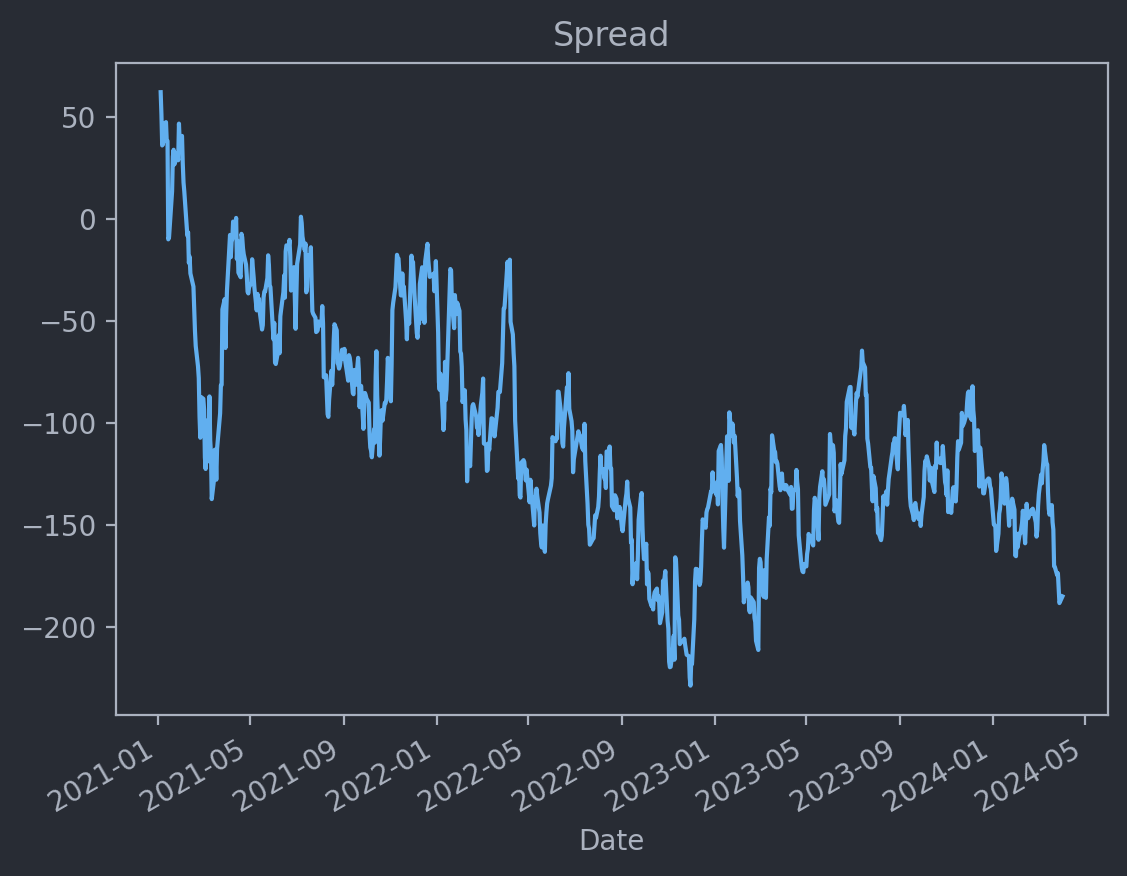

In [17]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df



SPREAD_WINDOW = None
spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread

pair_df['spread'].plot(title='Spread')


### <a id='toc1_1_5_'></a>[Create Target](#toc0_)

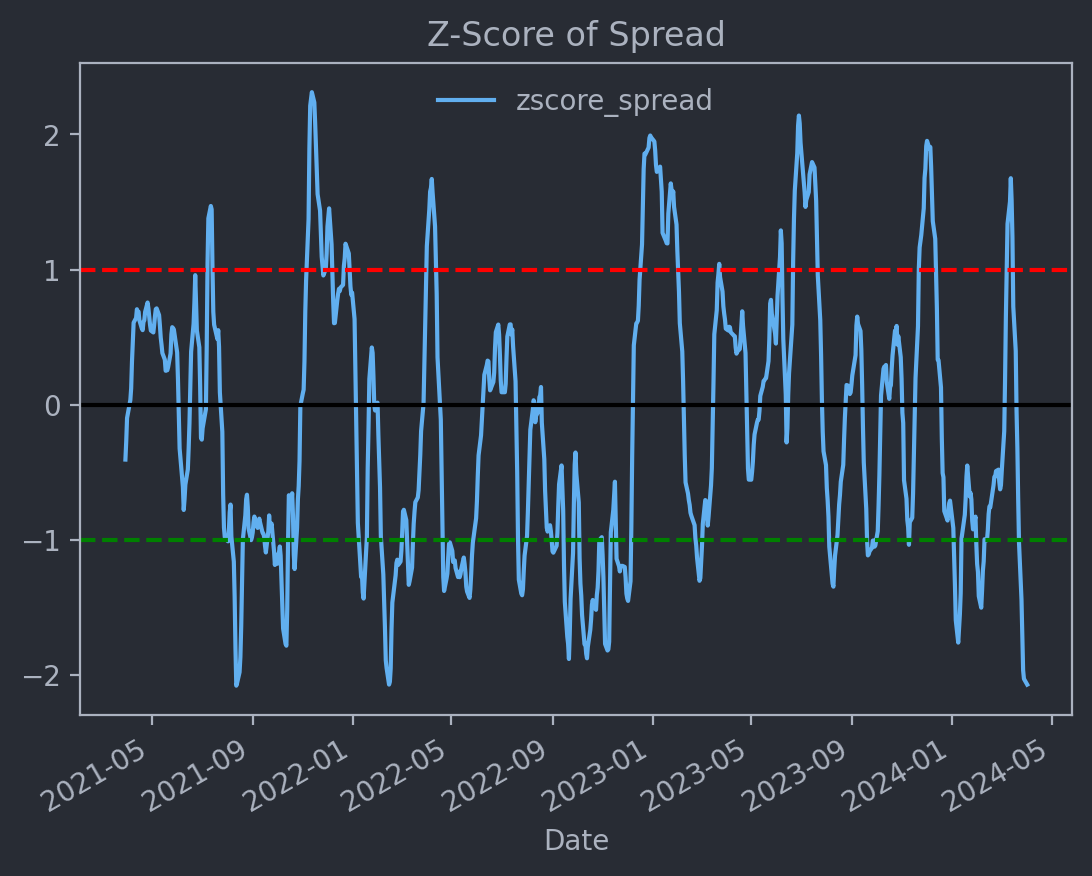

,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,twitter_pos_sentiment_count_S2_ma40,news_pos_sentiment_count_S2_ma40,news_pos_sentiment_count_S1_ma80,news_sentiment_daily_avg_S1_ma80,twitter_pos_sentiment_count_S1_ma80,news_sentiment_daily_avg_S2_ma80,twitter_pos_sentiment_count_S2_ma80,news_pos_sentiment_count_S2_ma80,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,267.5800,260.16,267.00,3572043.0,265.00,264.246667,267.081107,268.832227,271.666667,261.412227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.319539,NaN
2021-01-05,273.5000,262.57,263.88,4207081.0,270.93,269.000000,273.175260,275.754740,279.930000,264.824740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.567812,NaN
2021-01-06,288.3800,273.10,276.29,6383530.0,285.55,282.343333,288.180293,291.786373,297.623333,276.506373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.170164,NaN
2021-01-07,295.8894,286.68,287.77,4009730.0,291.65,291.406467,294.924457,297.097876,300.615867,287.888476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.702417,NaN
2021-01-08,292.2800,285.06,292.00,2800784.0,290.08,289.140000,291.898040,293.601960,296.360000,286.381960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.574477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,410.4600,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,36.000,0.900,2.4125,0.017359,11.6500,-0.011185,27.0875,1.1750,-174.747648,-1.442855
2024-03-26,409.3300,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,35.100,0.850,2.4000,0.017306,11.8000,-0.011215,27.2625,1.1625,-173.792140,-1.707300
2024-03-27,415.4900,408.37,409.62,2353629.0,415.25,413.036667,415.756507,417.436827,420.156667,410.316827,...,35.025,0.900,2.3875,0.018410,11.9875,-0.011123,27.3625,1.1875,-181.067986,-1.967804


In [18]:

# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

# Moving Z score Calculation (Trading Signal)
ma_high = pair_df.spread.rolling(window=60).mean()
ma_low = pair_df.spread.rolling(window=5).mean()
std_high = pair_df.spread.rolling(window=60).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


pair_df['zscore_spread'].plot(title='Z-Score of Spread')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.show()
pair_df

In [19]:
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


SPLIT_SIZES = [0.4, 0.1, 0.5]

def create_dataset(data, look_back, target_col="spread_close", split_sizes=SPLIT_SIZES, drop_cols: list = [], verbose=False):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size


    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[train_size + val_size:]
    
    if verbose:
        print("------Dataset Information------")
        print(tabulate([
                ["Train", train_size, data.index[0].date(), data.index[train_size-1].date()], 
                ["Val", val_size, data.index[train_size].date(), data.index[train_size + val_size - 1].date()],
                ["Test", test_size, data.index[train_size + val_size].date(), data.index[-1].date()]],
            ["Set", "Size", "Min Date", "Max Date"]))
        
    return train_data, val_data, test_data

def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



## <a id='toc1_2_'></a>[Dataset Setup](#toc0_)

In [20]:
# Parameters
LOOK_BACK = 2
DROP_COLS = [
   'zscore_spread',
    'spread',
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

In [21]:
print(
     (X_train.index.min(), X_train.index.max(),),
    ( X_test.index.min(), X_test.index.max()),
    (X_val.index.min(), X_val.index.max())
)


(Timestamp('2021-04-22 00:00:00'), Timestamp('2022-06-21 00:00:00')) (Timestamp('2022-06-22 00:00:00'), Timestamp('2024-03-26 00:00:00')) (Timestamp('2022-06-22 00:00:00'), Timestamp('2022-10-04 00:00:00'))


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame

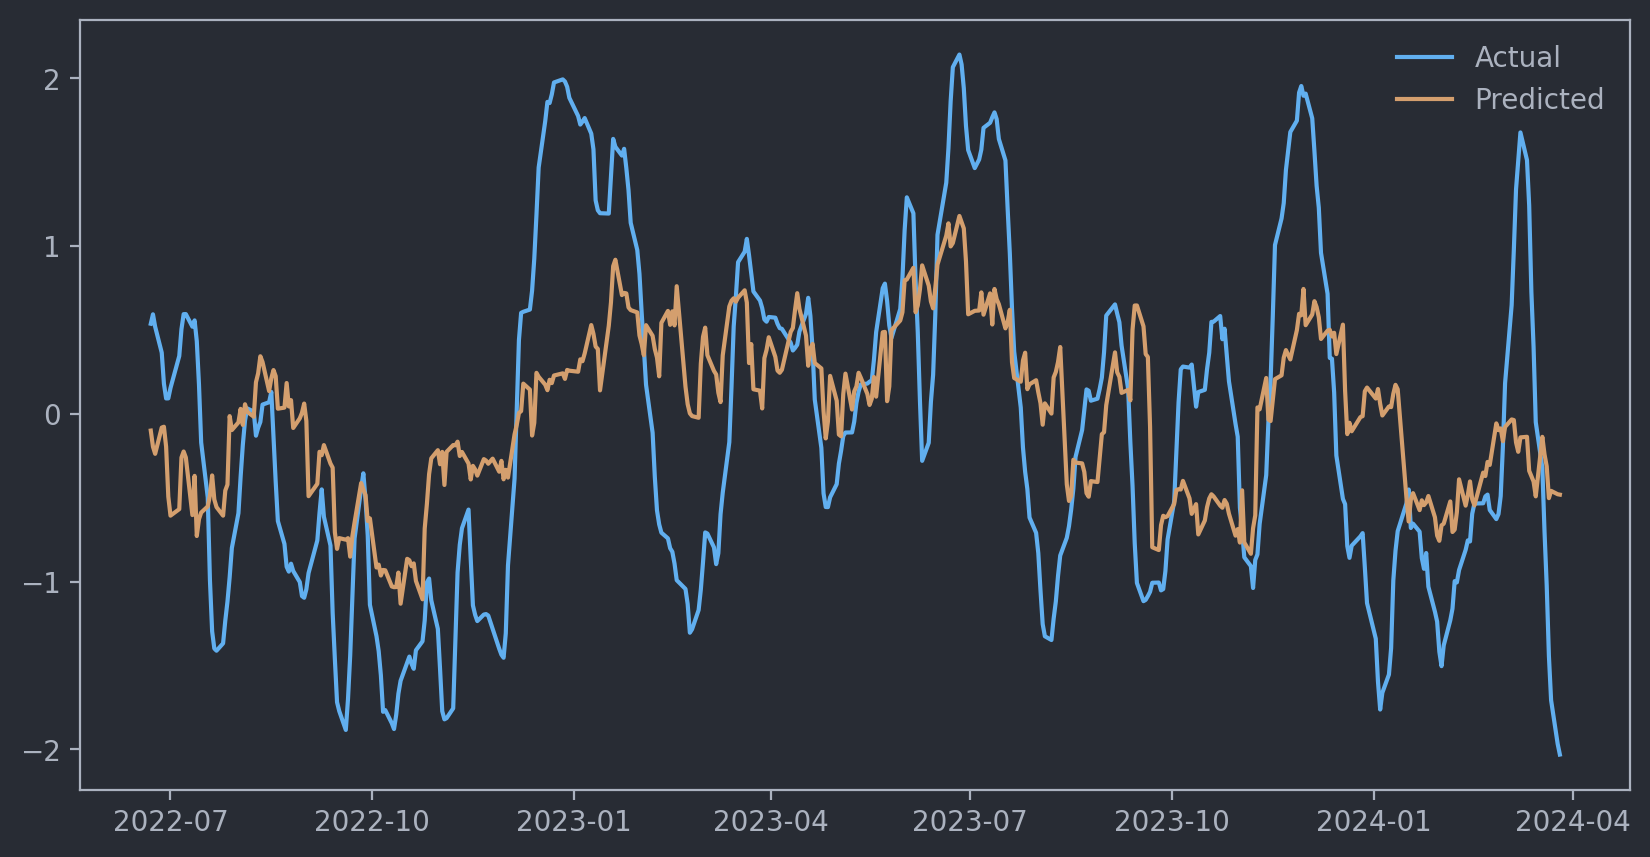

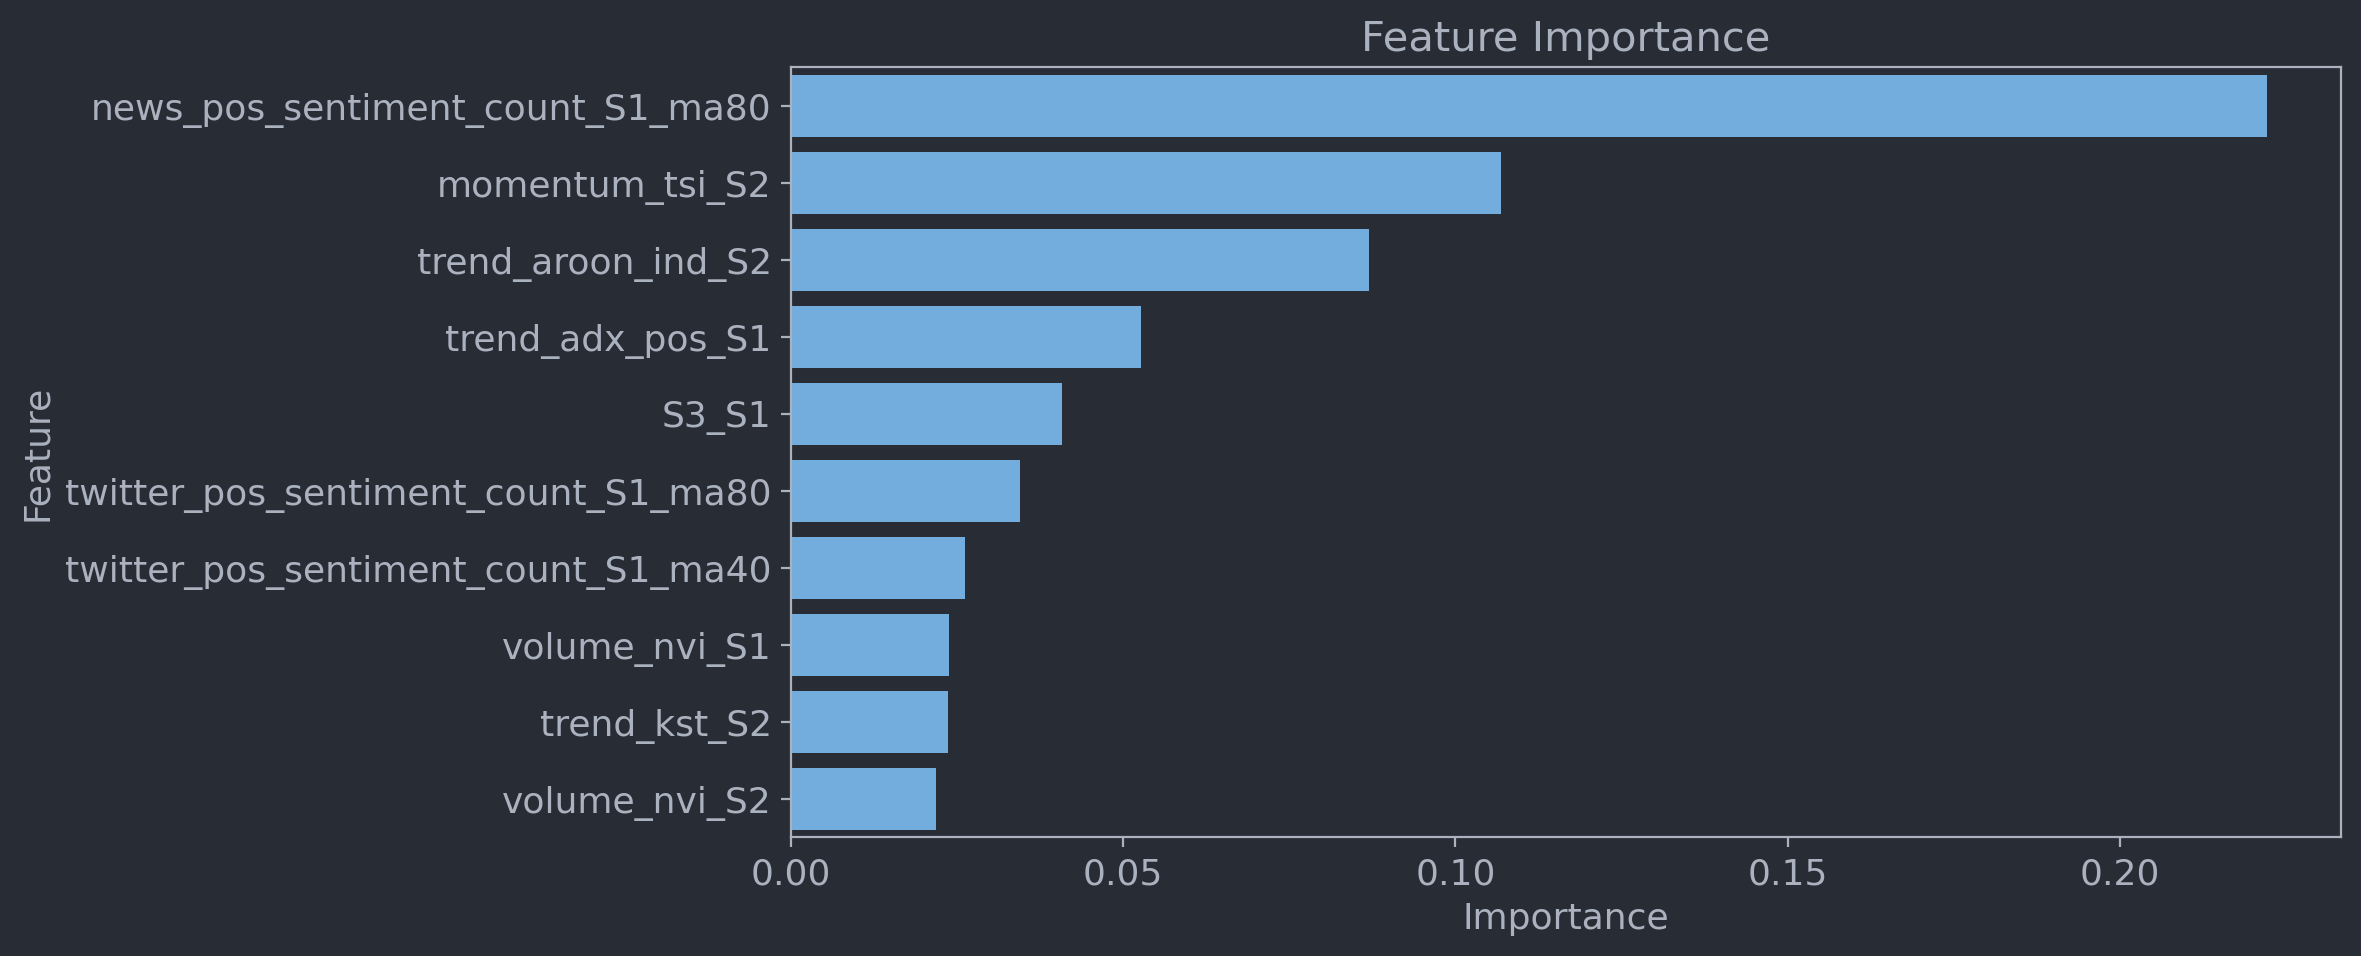

In [24]:

from sklearn.ensemble import GradientBoostingRegressor

errors = ['squared_error', 'absolute_error', 'huber', 'quantile']
# ---- Model Training ----
model_reg = GradientBoostingRegressor(n_estimators=100, loss=errors[0], random_state=42
                                      )
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

# get feature importance
feature_importance = model_reg.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

# plot feature importance
fig = plt.figure(figsize=(10, 5))
sns.barplot(x="importance", y="feature", data=feature_importance_df.iloc[:10,:])
# incrase y-axis label size
plt.yticks(fontsize=13)
# increase global font size
plt.xticks(fontsize=13)
plt.xlabel("Importance", fontsize=13)
plt.ylabel("Feature", fontsize=13)

plt.title("Feature Importance", fontsize=15)
# plt.tight_layout()
plt.show()



R2: 0.77, MAE: 0.39, MAPE: 79.96%

R2: 0.77, MAE: 0.39


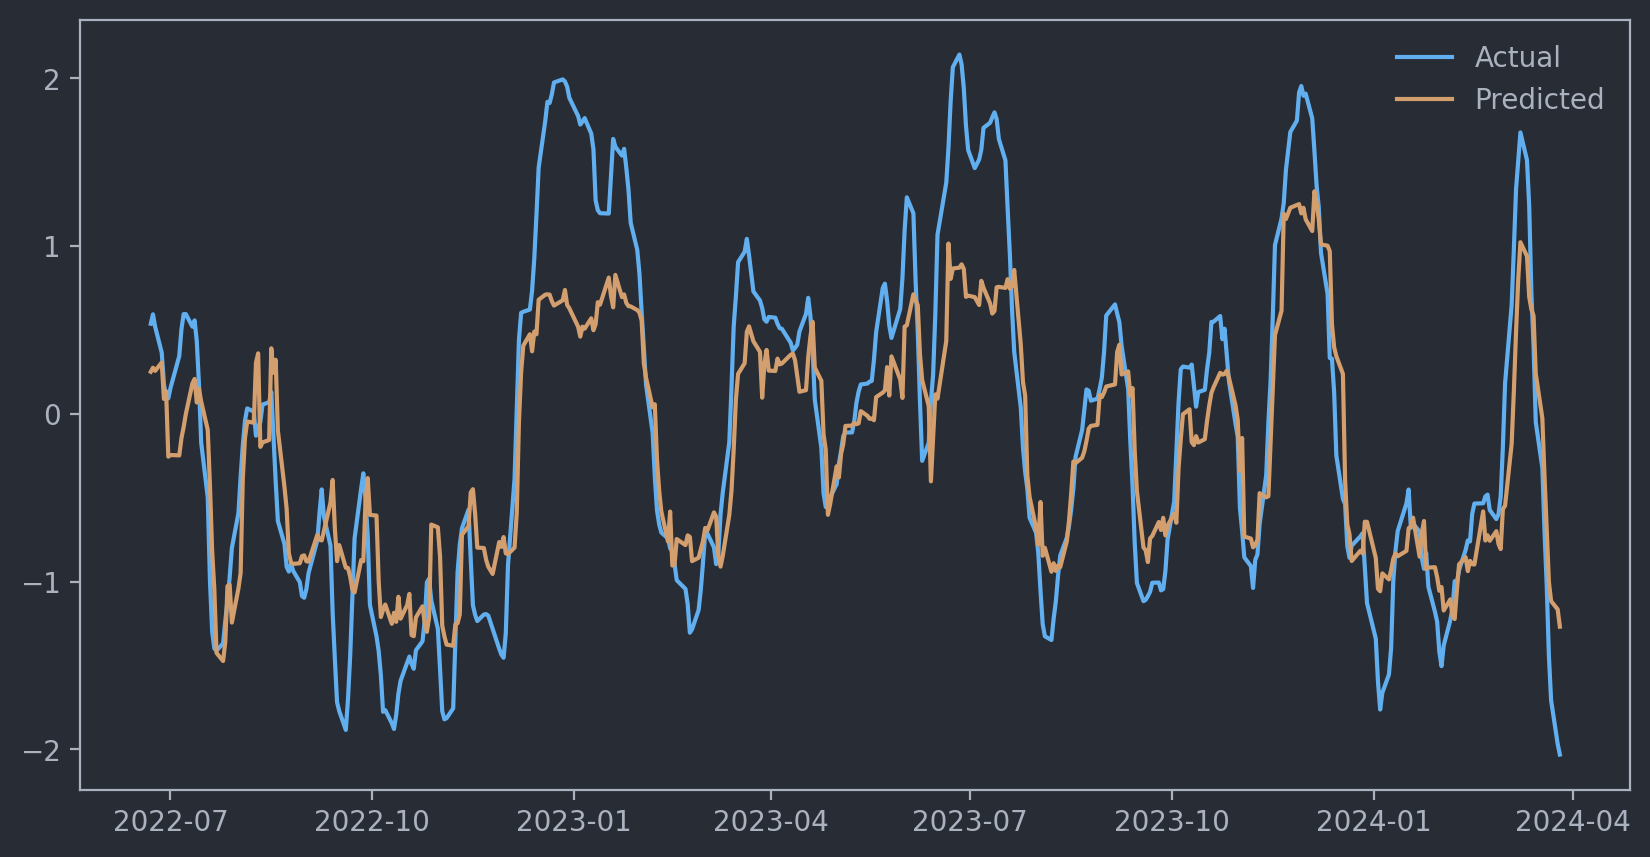

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Parameters
LOOK_BACK = 2
DROP_COLS = [
#    'zscore_spread',
#     'spread',
]

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])

model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)
model_results['Gradient Boosting Regressor'] = calculate_metrics(
    y_test, y_pred)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nR2: {r2:.2f}, MAE: {mae:.2f}")

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()


In [26]:
print('Original Feature Dim:', feature_importance_df.shape[0])

# Can Change Thresholds, By no means are these the best thresholds
# Should use another method for feature selection, this was just for demonstration
low_importance_df = feature_importance_df[(feature_importance_df['importance'] < .1) & (feature_importance_df['importance'] > -.1)]
print('Low Importance Feature Dim:', low_importance_df.shape[0])

low_importance_cols = low_importance_df.feature.to_list()
high_importance_df = feature_importance_df[(feature_importance_df['importance'] >= .1) | (feature_importance_df['importance'] <= -.1)]

Original Feature Dim: 280
Low Importance Feature Dim: 280


### <a id='toc1_2_1_'></a>[Train regression again with low importance columns removed](#toc0_)


R2: 0.84, MAE: 0.33, MAPE: 101.35%


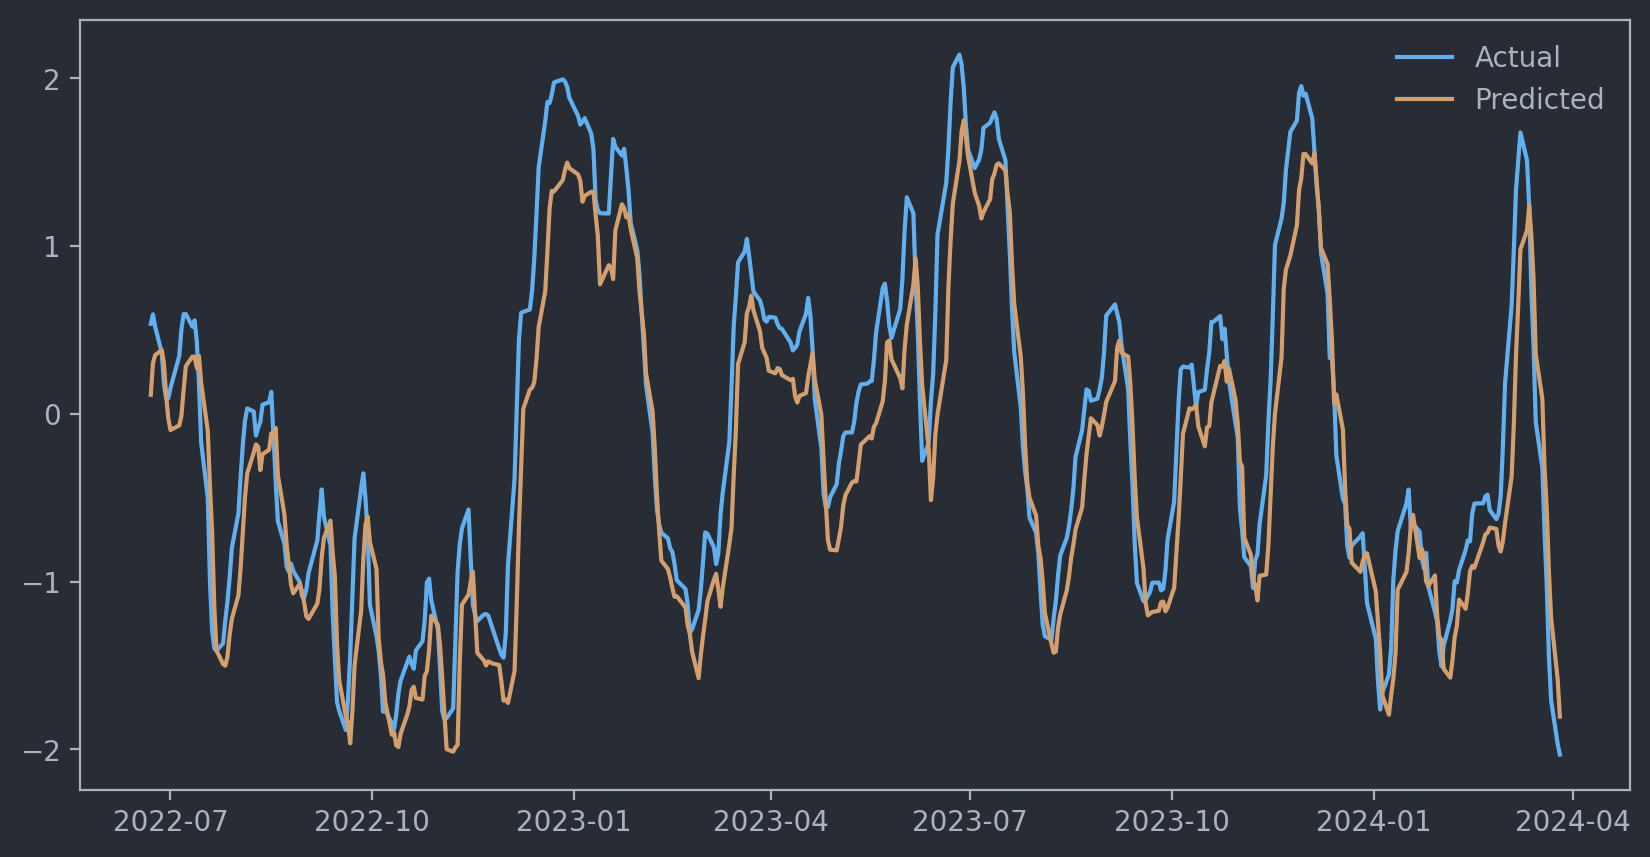

In [27]:

train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=low_importance_cols
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Combine val and test data since were not using Deep learning or hyper-param tuning 
X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])



model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

plt.show()

# <a id='toc2_'></a>[General Setup](#toc0_)

In [28]:
def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def norm_plot(df):
    df=df.copy()
    df = (df - df.mean()) / df.std()
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


def create_dataset(data, look_back, target_col="spread_close", split_sizes=SPLIT_SIZES, drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size


    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[train_size + val_size:]
 
    print("------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[0].date(), data.index[train_size-1].date()], 
            ["Val", val_size, data.index[train_size].date(), data.index[train_size + val_size - 1].date()],
            ["Test", test_size, data.index[train_size + val_size].date(), data.index[-1].date()]],
        ["Set", "Size", "Min Date", "Max Date"]))
    
    return train_data, val_data, test_data

def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
sys.path.insert(0, os.path.dirname(os.getcwd()) + '/.templates')
warnings.filterwarnings('ignore')   
# plt.style.use('custom_onedark')

data_dir = '../data/'
price_history_dir = data_dir + f'{data_dir}price_history/'
sentiment_dir = data_dir + f'{data_dir}sentiments/'
ti_dir = data_dir + f'{data_dir}technical_indicators/'

import glob

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs= pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')


# Load Ticker History, Sentiment and Technical Indicators
data = {}
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))

    data[ticker] = TickerData(ticker)

# Pair Selection
PAIR_IDX = 0
ADD_SENTIMENT_MA = True

pair = pairs[PAIR_IDX]
print(pair)

# Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
if ADD_SENTIMENT_MA:
    pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns)

# Join Technical Indicators
pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")


# ---- Dataset Setup ----
# We want to predict the z-score of spread, to forecast deviations from the mean

# The Z-score of the spread will be used to determine when to buy and sell
# We use a low/high moving average to calculate the z-score. 
# This is so that the z-score is not affected by the spread increasing over time
# Can play around with the window sizes to see what works best

SPREAD_WINDOW = None
MA_HIGH = 45
MA_LOW = 4

# Parameters
LOOK_BACK = 3
DROP_COLS = [

]
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "r2": r2_score(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MSE: {metric_frame['mse']:.2f}, RMSE: {metric_frame['rmse']:.2f}")
    return metric_frame


spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
pair_df['spread'] = spread


ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
std_high = pair_df.spread.rolling(window=MA_HIGH).std()

moving_zscore = (ma_low - ma_high) / std_high
pair_df['zscore_spread'] = moving_zscore


train_data, val_data, test_data = create_dataset(
    pair_df, 
    look_back=LOOK_BACK, 
    target_col="zscore_spread", 
    drop_cols=DROP_COLS
)

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

X_test = pd.concat([X_val, X_test])
y_test = pd.concat([y_val, y_test])





def train(model, X_train, y_train, X_test, y_test, model_results, plot=True, verbose=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = model.__class__.__name__
    # print(f"\n{model_name}")
    model_results[model_name] = {
        'metrics': calculate_metrics(y_test, y_pred),
        'model': model,
        'data': (X_train, y_train, X_test, y_test)
    }

    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(y_test.index, y_test, label="Actual")
        ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
        ax.legend()
        plt.show()


base_models = [
    LinearRegression(),
    # KNeighborsRegressor(),
    GradientBoostingRegressor(random_state=42),
    RandomForestRegressor(n_estimators=100, random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),
]

for model in base_models:
    train(model, X_train, y_train, X_test, y_test, model_results, plot=True)

pair_df

### <a id='toc2_1_1_'></a>[Benchmark Gradient Boosting Regressor Model](#toc0_)


R2: 0.57, MAE: 0.57, MSE: 0.49, RMSE: 0.70


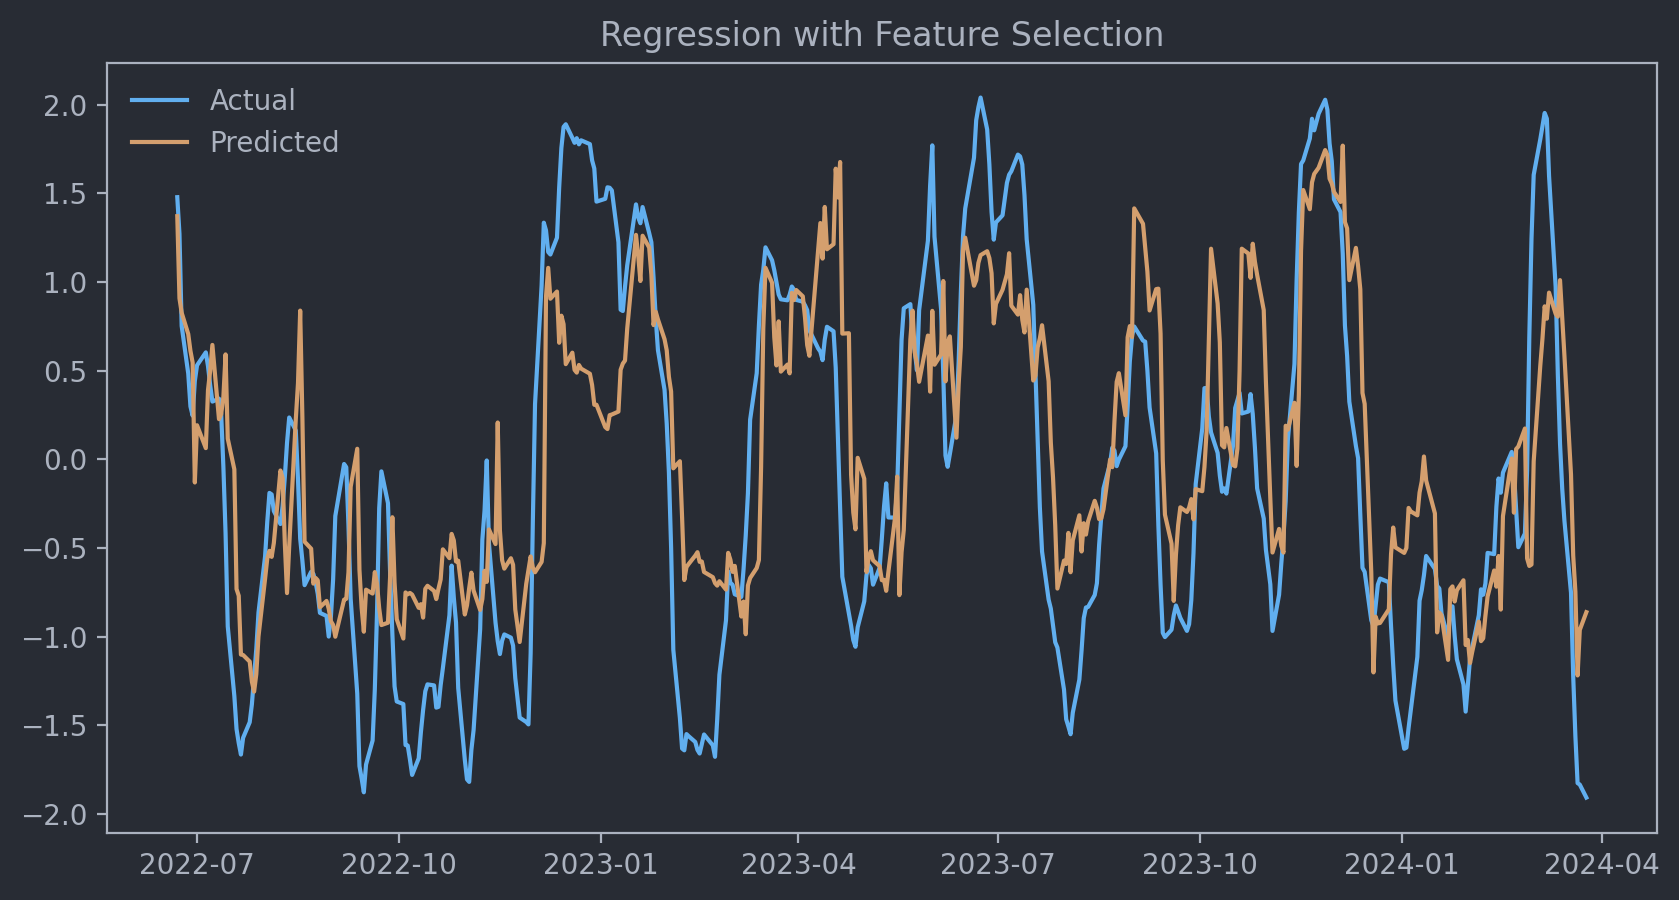

In [31]:
model_reg = GradientBoostingRegressor()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)


model_results['Regression with Feature Selection'] = calculate_metrics(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title('Regression with Feature Selection')
plt.legend()

plt.show()


### <a id='toc2_1_2_'></a>[LSTM and BiLSTM](#toc0_)

In [58]:
import tensorflow as tf
keras = tf.keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.models import save_model, load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler


model_results2 = {}

# Prepare and scale the data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

# Pad and reshape data for LSTM
padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

X_train_padded = np.pad(X_train, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_val_padded = np.pad(X_val, ((0, 0), (0, padding_val)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, 0), (0, padding_test)), 'constant', constant_values=0)

X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))



# Constants and callbacks
LR = 0.0001
EPOCHS = 100
BATCH_SIZE = 16

lstm_csv_logger = CSVLogger('lstm_training.csv')
bilstm_csv_logger = CSVLogger('bilstm_training.csv')

model_checkpoint_lstm = ModelCheckpoint('best_model_lstm.keras', monitor='val_loss', mode='min')
model_checkpoint_bilstm = ModelCheckpoint('best_model_bilstm.keras', monitor='val_loss', mode='min')

# Vanilla LSTM model
model_vanilla_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_vanilla_lstm = History()

model_vanilla_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_vanilla_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
                       callbacks=[early_stopping, history_vanilla_lstm], batch_size=BATCH_SIZE)

y_pred_vanilla_lstm = model_vanilla_lstm.predict(X_test_lstm)
model_results2['Vanilla LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_vanilla_lstm.flatten()),
    'model': model_vanilla_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# LSTM model
model_lstm = Sequential([
    LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_lstm = History()

model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
               callbacks=[early_stopping, history_lstm, lstm_csv_logger, model_checkpoint_lstm],
               batch_size=BATCH_SIZE)

y_pred_lstm = model_lstm.predict(X_test_lstm)
model_results2['LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_lstm.flatten()),
    'model': model_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# BiLSTM model
# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),  
    Bidirectional(LSTM(50)),
    Dropout(0.2),  
    Dense(50, activation='relu'),  
    Dense(1)  # Output layer
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()
model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])


optimizer = Adam(learning_rate=LR)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()

model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1,
                 callbacks=[early_stopping, history_bilstm, bilstm_csv_logger, model_checkpoint_bilstm],
                 batch_size=BATCH_SIZE)

y_pred_bilstm = model_bilstm.predict(X_test_lstm)
model_results2['BiLSTM with Dropout'] = {
    'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
    'model': model_bilstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0070 - mae: 1.0070 - mse: 1.3287 - val_loss: 1.2839 - val_mae: 1.2839 - val_mse: 1.9701
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0009 - mae: 1.0009 - mse: 1.3130 - val_loss: 1.2534 - val_mae: 1.2534 - val_mse: 1.8844
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9905 - mae: 0.9905 - mse: 1.3246 - val_loss: 1.2260 - val_mae: 1.2260 - val_mse: 1.8081
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9448 - mae: 0.9448 - mse: 1.1968 - val_loss: 1.1993 - val_mae: 1.1993 - val_mse: 1.7360
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9942 - mae: 0.9942 - mse: 1.2925 - val_loss: 1.1717 - val_mae: 1.1717 - val_mse: 1.6621
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9349 - mae: 0.9349 - mse: 1.1864 - val_loss: 1.1391 - val_mae: 1.1391 - val_mse: 1.5778
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9191 - mae: 0.9191 - mse: 1.1279 - val_loss:

In [78]:
history_lstm.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

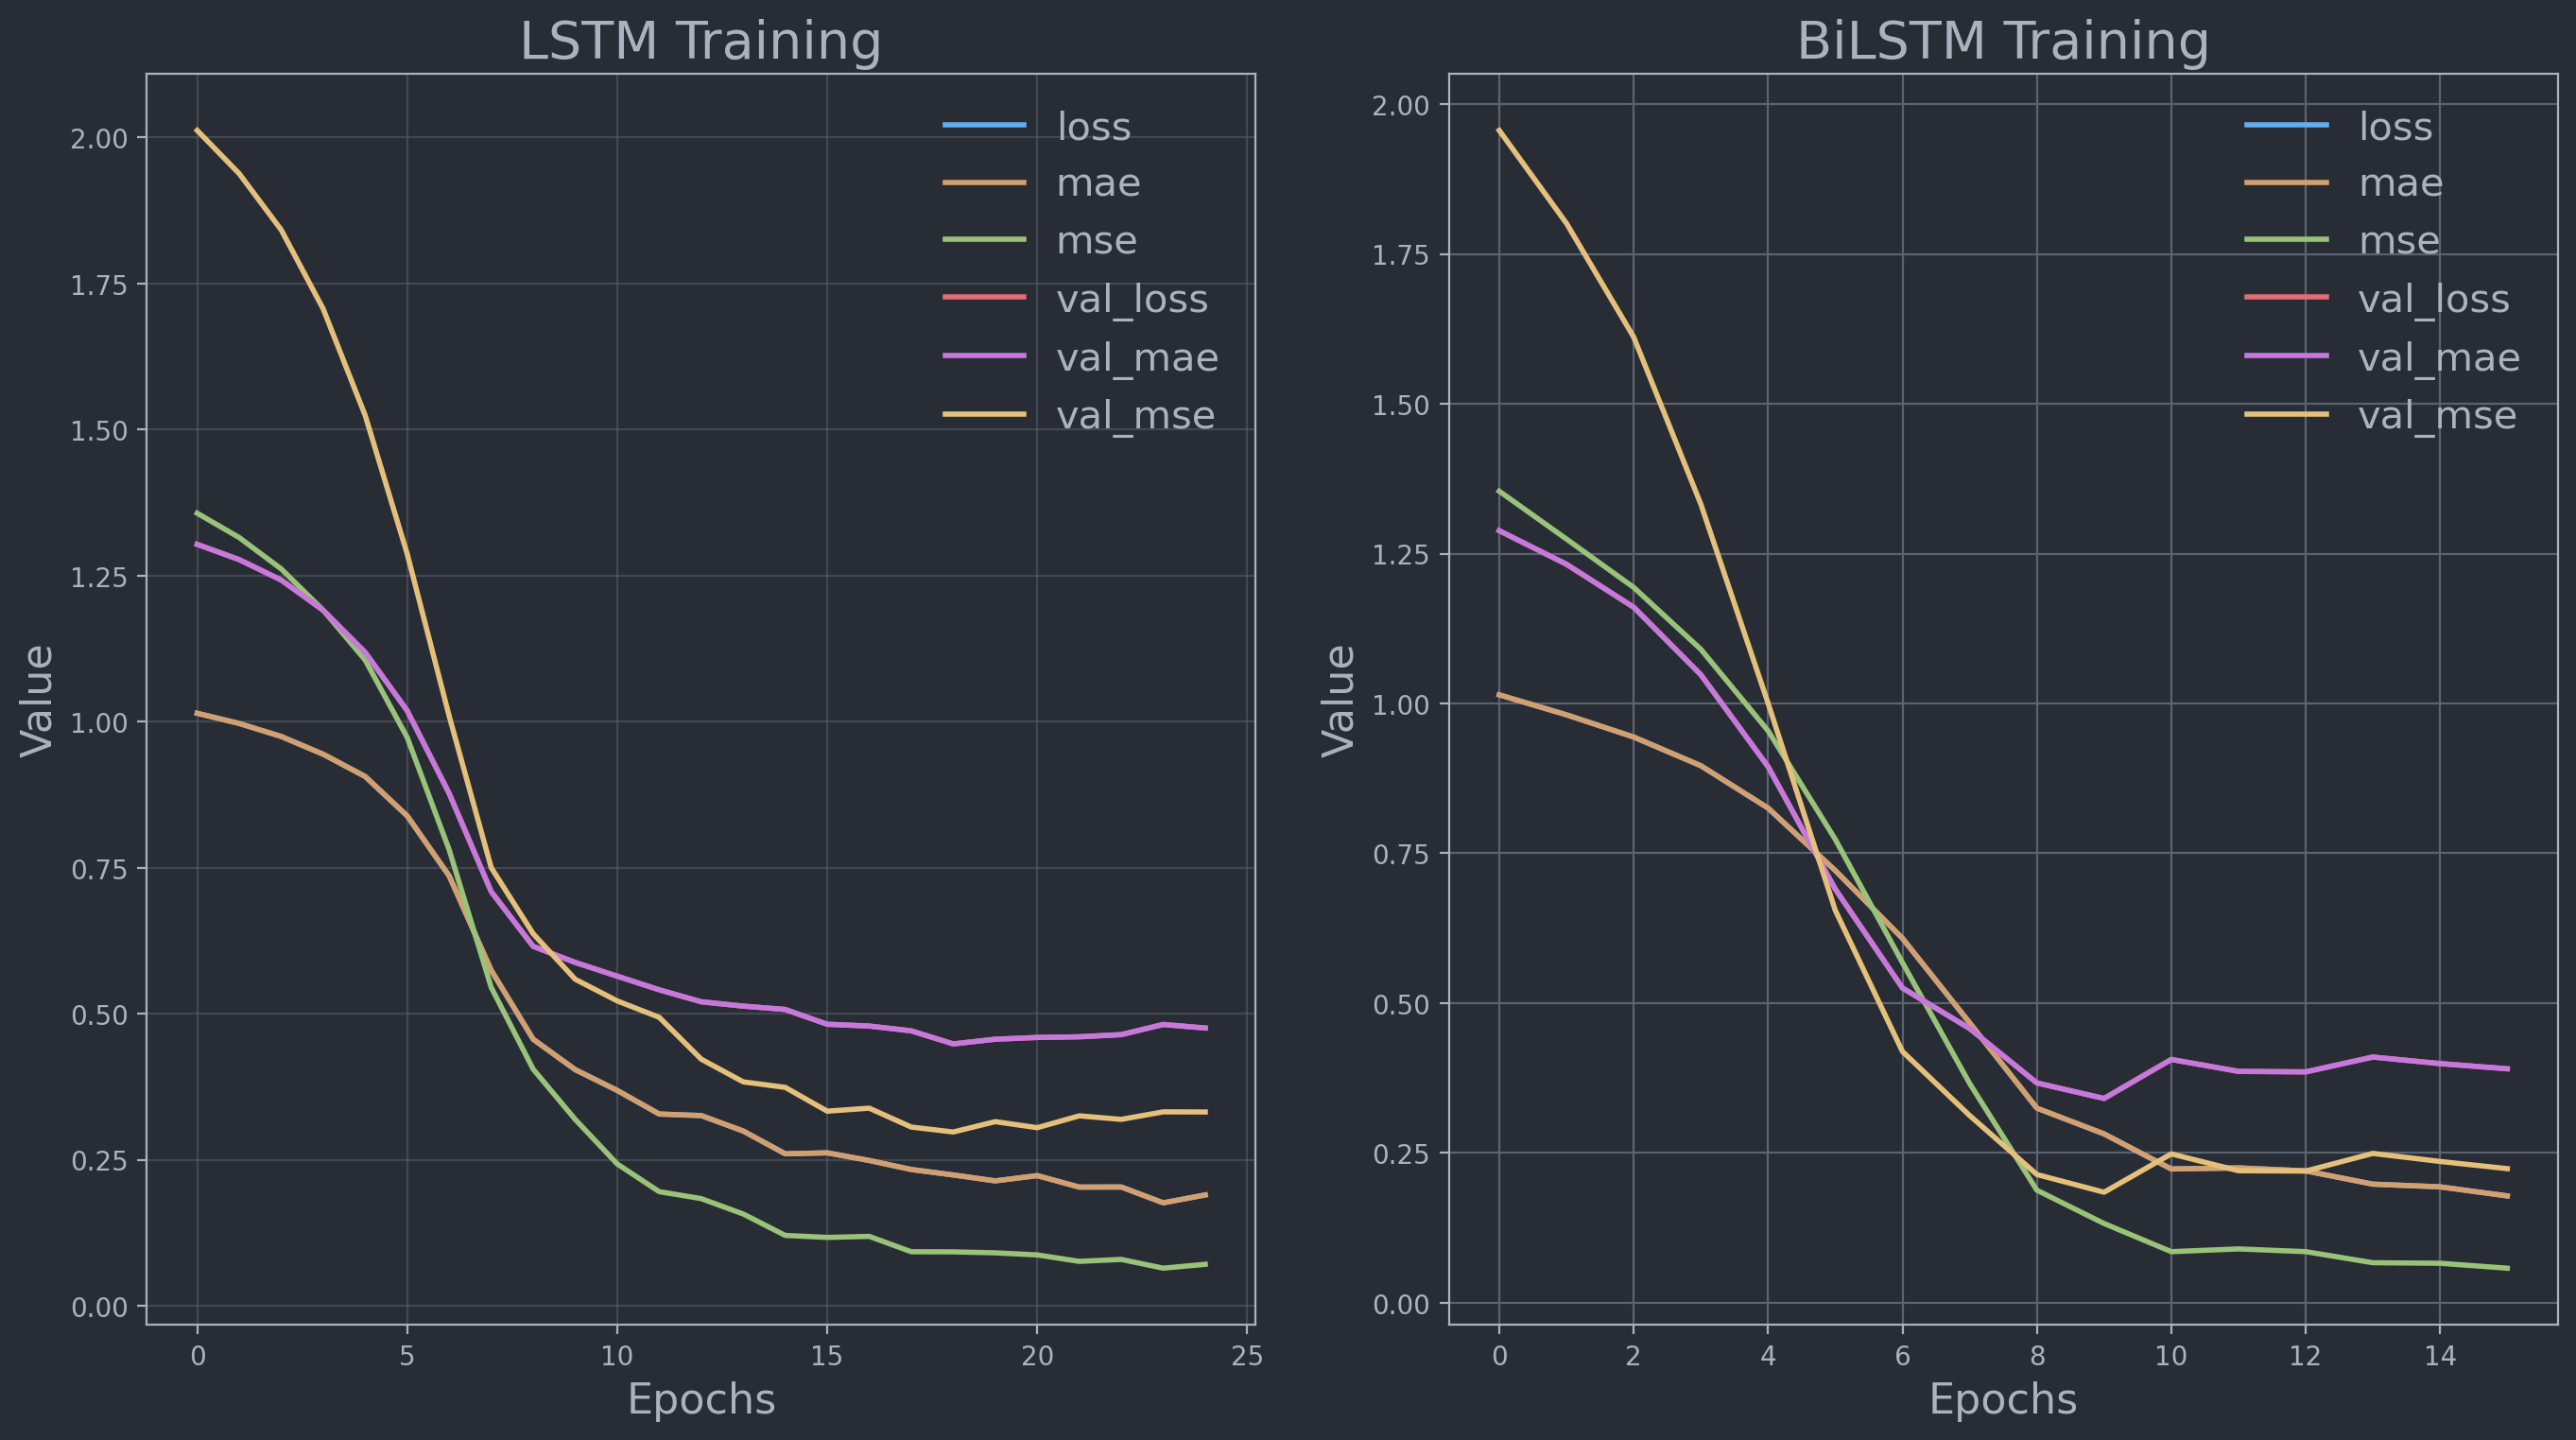

In [93]:
fig = plt.figure(figsize=(14, 8))

# Plot for LSTM
plt.subplot(121)
lstm_stats = pd.DataFrame(history_lstm.history) 
plt.plot(lstm_stats, linewidth=2)
plt.title('LSTM Training', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.grid(True, alpha=0.5)
plt.legend(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'], fontsize=15, frameon=True, fancybox=True)

# Plot for BiLSTM
plt.subplot(122)
bilstm_stats = pd.DataFrame(history_bilstm.history)
plt.plot(bilstm_stats, linewidth=2)
plt.title('BiLSTM Training', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.grid(True)
plt.legend(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'], fontsize=15, frameon=True, fancybox=True)

plt.tight_layout(pad=2)
plt.show()

# <a id='toc3_'></a>[Hyperparameter Tuning of LSTM Model with Keras Tuner](#toc0_)

In [24]:
import keras_tuner as kt


2024-05-08 05:49:14.950750: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 05:49:17.483245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 05:49:38.015789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-05-08 05:58:53.933789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 819 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:31:00.0, compute capability: 8.0


Epoch 1/100


2024-05-08 05:58:56.694762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.9300 - mae: 0.9300 - mse: 1.1704 - val_loss: 0.7113 - val_mae: 0.7113 - val_mse: 0.7056
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6698 - mae: 0.6698 - mse: 0.7813 - val_loss: 0.8018 - val_mae: 0.8018 - val_mse: 0.8643
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5024 - mae: 0.5024 - mse: 0.4645 - val_loss: 1.0634 - val_mae: 1.0634 - val_mse: 1.4813
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3448 - mae: 0.3448 - mse: 0.2149 - val_loss: 0.9409 - val_mae: 0.9409 - val_mse: 1.1971
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3299 - mae: 0.3299 - mse: 0.2042 - val_loss: 0.7713 - val_mae: 0.7713 - val_mse: 0.7586
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2504 - mae: 0.2504 - mse: 0.1241 - val_loss: 0.8345 - val_mae: 0.8345 - val_mse: 0.8755
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2260 - mae: 0.2260 - mse: 0.1118 - val_loss: 0.8259 - va

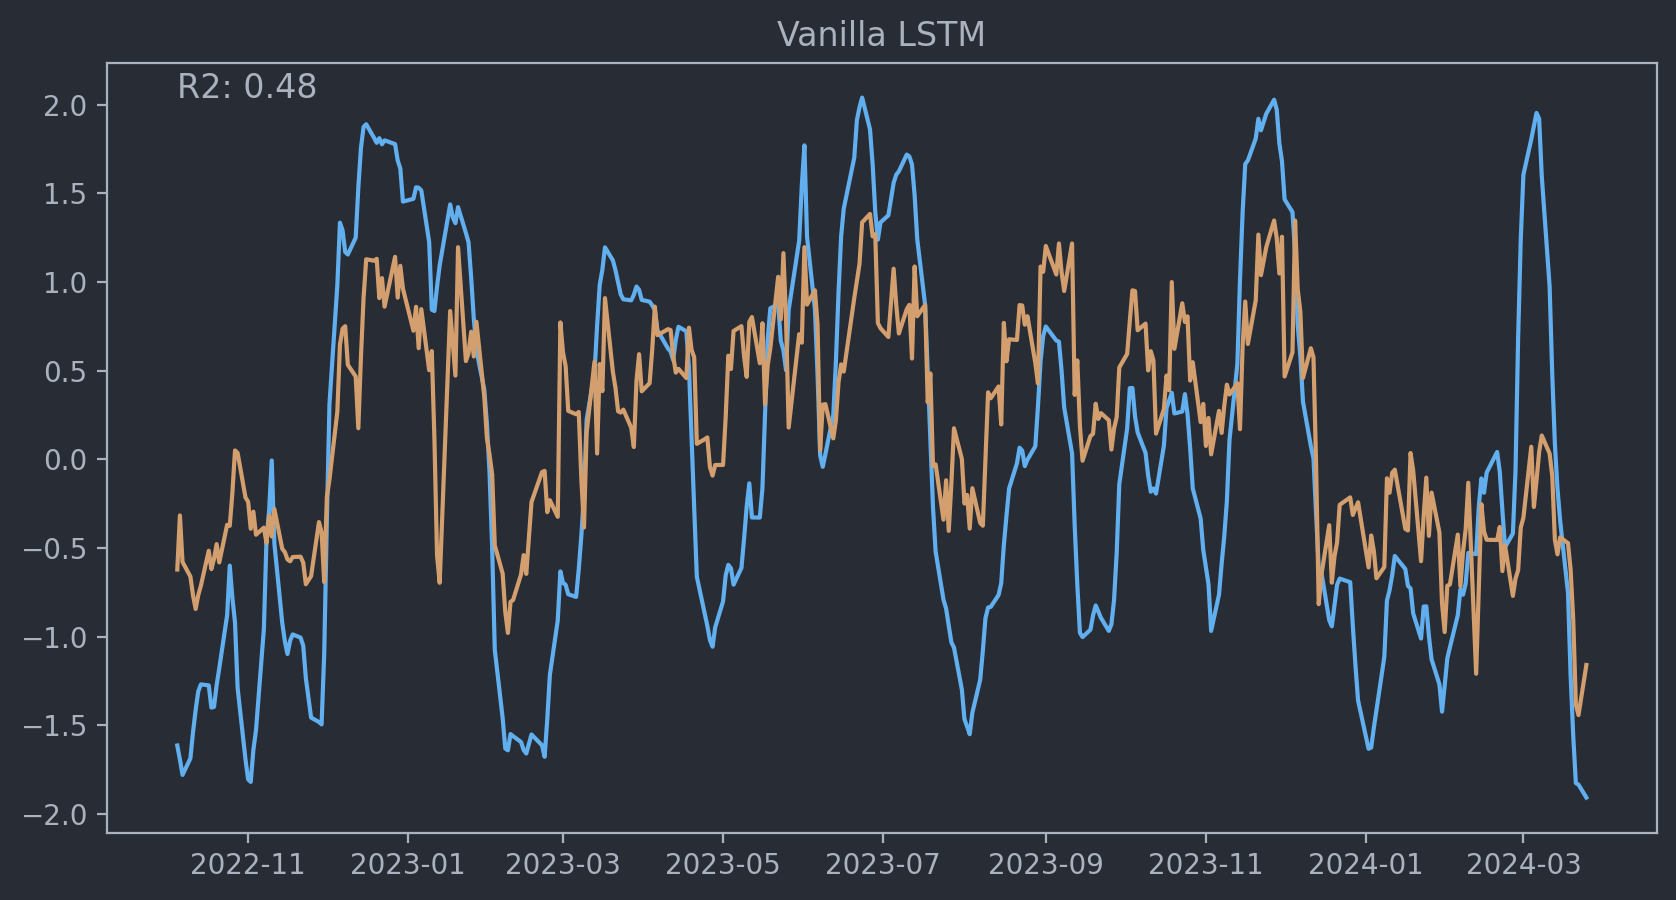

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.8868 - mae: 0.8868 - mse: 1.1171 - val_loss: 0.7556 - val_mae: 0.7556 - val_mse: 0.8161
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6554 - mae: 0.6554 - mse: 0.6968 - val_loss: 0.9810 - val_mae: 0.9810 - val_mse: 1.2758
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4464 - mae: 0.4464 - mse: 0.3424 - val_loss: 0.8392 - val_mae: 0.8392 - val_mse: 0.8814
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4035 - mae: 0.4035 - mse: 0.2976 - val_loss: 0.7534 - val_mae: 0.7534 - val_mse: 0.7746
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3716 - mae: 0.3716 - mse: 0.2336 - val_loss: 0.6203 - val_mae: 0.6203 - val_mse: 0.4965
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3427 - mae: 0.3427 - mse: 0.2009 - val_loss: 0.7389 - val_mae: 0.7389 - val_mse: 0.7345
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2645 - mae: 0.2645 - mse: 0.1180 - val_l

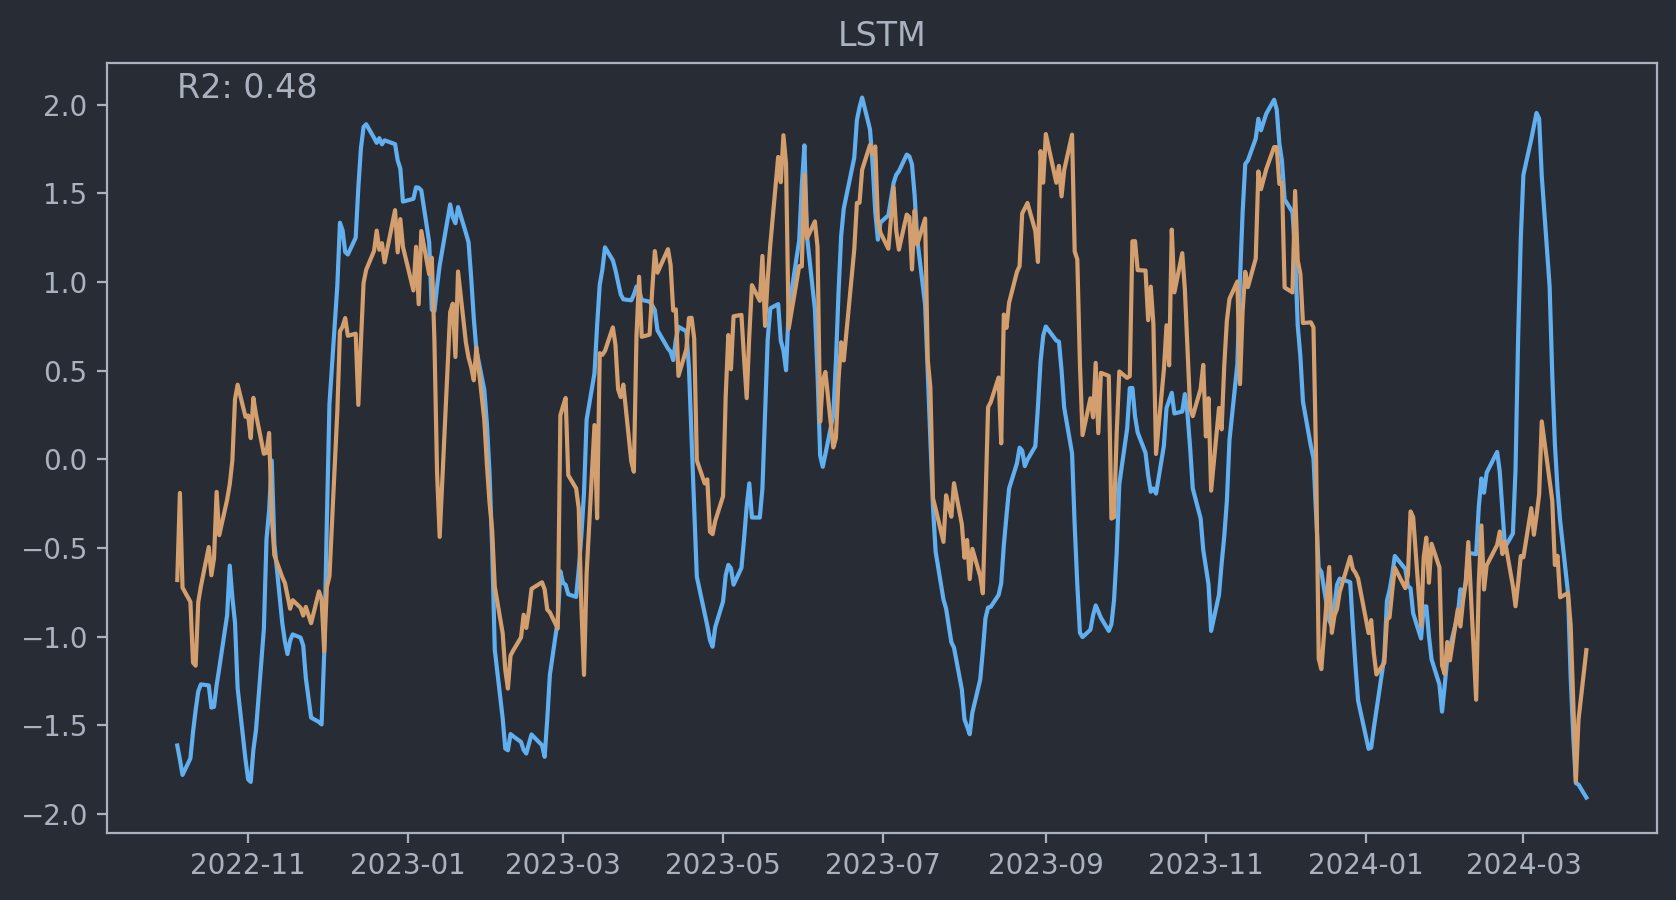

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.8719 - mae: 0.8719 - mse: 1.1034 - val_loss: 0.7203 - val_mae: 0.7203 - val_mse: 0.7661
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6067 - mae: 0.6067 - mse: 0.6358 - val_loss: 0.8459 - val_mae: 0.8459 - val_mse: 0.9819
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3536 - mae: 0.3536 - mse: 0.2171 - val_loss: 0.6940 - val_mae: 0.6940 - val_mse: 0.6565
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3074 - mae: 0.3074 - mse: 0.1687 - val_loss: 0.8161 - val_mae: 0.8161 - val_mse: 0.8685
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2630 - mae: 0.2630 - mse: 0.1402 - val_loss: 0.8053 - val_mae: 0.8053 - val_mse: 0.8751
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2354 - mae: 0.2354 - mse: 0.1028 - val_loss: 0.7289 - val_mae: 0.7289 - val_mse: 0.7396
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2286 - mae: 0.2286 - mse: 0.0996 - val

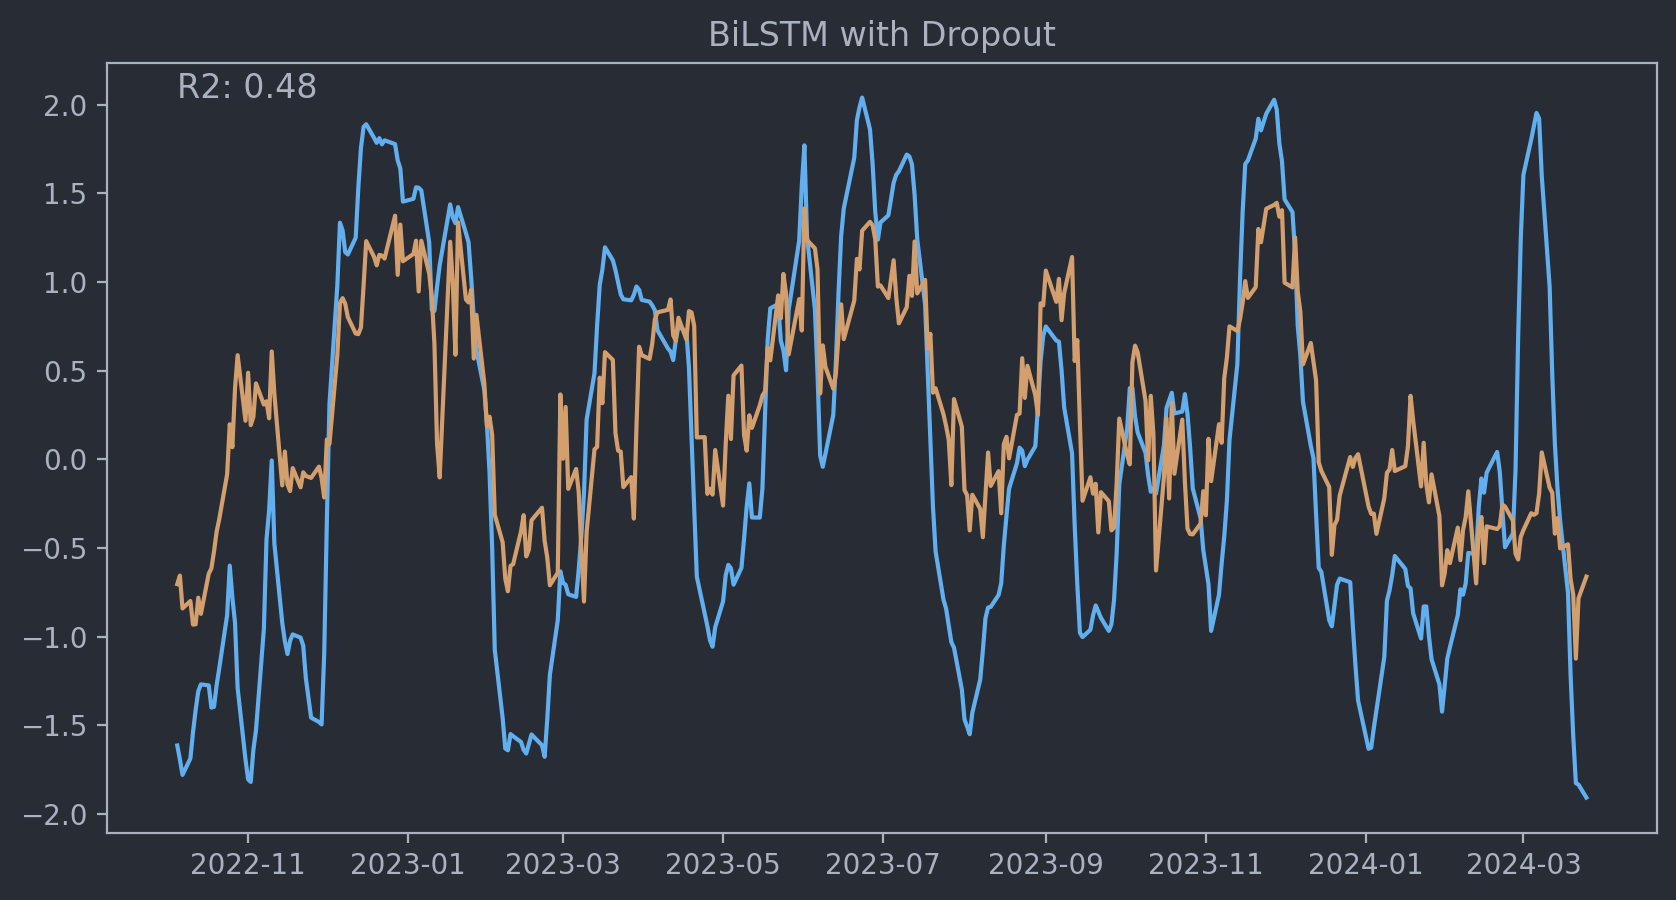

In [27]:
import tensorflow as tf
keras = tf.keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Flatten
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.optimizers import Adam



X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad training, validation and testing feature sets
X_train_padded = np.pad(X_train,  ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_val_padded = np.pad(X_val,  ((0, 0), (0, padding_val)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test,  ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape all sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))


from keras.callbacks import CSVLogger, ModelCheckpoint

LR = 0.001
EPOCHS = 100
BATCH_SIZE = 16



# CSVLogger callback
lstm_csv_logger = CSVLogger('lstm_training.csv')
bilstm_csv_logger = CSVLogger('bilstm_training.csv')


# ModelCheckpoint callback
model_checkpoint_lstm = ModelCheckpoint('best_model_lstm.keras',            
                                        # save_best_only=True,
                                         monitor='val_loss', mode='min')
model_checkpoint_bilstm = ModelCheckpoint('best_model_bilstm.keras',        
                                          # save_best_only=True,
                                           monitor='val_loss', mode='min')



# Build the LSTM model
model_vanilla_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(50),
    Dense(1)
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_vanilla_lstm = History()

model_vanilla_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Fit the model
model_vanilla_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, callbacks=[early_stopping, history_vanilla_lstm], batch_size=BATCH_SIZE)

# Predict
y_pred_vanilla_lstm = model_vanilla_lstm.predict(X_test_lstm)

# Evaluate
model_results['Vanilla LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_vanilla_lstm.flatten()),
    'model': model_vanilla_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_vanilla_lstm.flatten(), label="Predicted Vanilla LSTM")
plt.title('Vanilla LSTM')
# Add R2 Score to Plot
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['Vanilla LSTM']['metrics']['r2']:.2f}", fontsize=14)
plt.show()




model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])
model_lstm = Sequential([
    LSTM(200, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(200, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])


optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_lstm = History()

model_lstm.compile(optimizer=optimizer, loss='mae',metrics=['mae', 'mse'],)

# Fit the model

model_lstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, 
               callbacks=[early_stopping, history_lstm, lstm_csv_logger, model_checkpoint_lstm],
                batch_size=BATCH_SIZE, 
               )
model_lstm.history.history
# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Evaluate
model_results['LSTM'] = {
    'metrics': calculate_metrics(y_test, y_pred_lstm.flatten()),
    'model': model_lstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_lstm.flatten(), label="Predicted LSTM")
plt.title('LSTM')
# Add R2 Score to Plot
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['LSTM']['metrics']['r2']:.2f}", fontsize=14)
plt.show()




# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2), 
    Bidirectional(LSTM(50)),
    Dropout(0.2), 
    Dense(1)  # Output layer
])
from keras.layers import TimeDistributed

# Build the Bidirectional LSTM model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),  
    Dense(50, activation='relu'),
    Dense(1)  # Output layer
])

optimizer = Adam(learning_rate=LR)

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
history_bilstm = History()
model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

# Fit the model
# model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val), verbose=1, callbacks=[early_stopping, history_bilstm])
model_bilstm.fit(X_train_lstm, y_train, epochs=EPOCHS, validation_data=(X_val_lstm, y_val),  verbose=1, 
                 callbacks=[early_stopping, history_bilstm, bilstm_csv_logger, model_checkpoint_bilstm], 
                    batch_size=BATCH_SIZE,
)
                 
model_bilstm.history.history
# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
model_results['BiLSTM with Dropout'] = {
    'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
    'model': model_bilstm,
    'data': (X_train_lstm, y_train, X_test_lstm, y_test)
}

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_bilstm.flatten(), label="Predicted BiLSTM with Dropout")
# add r2 to plot and title
plt.title('BiLSTM with Dropout')
plt.text(y_test.index[0], y_test.max(), f"R2: {model_results['BiLSTM with Dropout']['metrics']['r2']:.2f}", fontsize=14)
plt.show()



In [28]:
# backup_model_results = model_results

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 3, 200)         │       156,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 3, 200)         │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 100)            │       100,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,506,905 (5.75 MB)

 Trainable params: 502,301 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,004,604 (3.83 MB)

,loss,mae,mse,val_loss,val_mae,val_mse
0,1.015478,0.841719,1.015478,0.694494,0.716831,0.694494
1,0.352954,0.470568,0.352954,0.713429,0.720065,0.713429
2,0.206394,0.350634,0.206394,1.013940,0.870306,1.013940
3,0.119026,0.265962,0.119026,0.878828,0.804943,0.878828
4,0.093848,0.233961,0.093848,0.657650,0.708794,0.657650
5,0.088506,0.225342,0.088506,0.917974,0.841498,0.917974
6,0.082182,0.222657,0.082182,1.081404,0.914365,1.081404
7,0.068335,0.199280,0.068335,0.738599,0.752414,0.738599
8,0.056228,0.184288,0.056228,1.004960,0.885021,1.004960
9,0.056728,0.180318,0.056728,0.760104,0.765892,0.760104


<Figure size 1000x500 with 0 Axes>

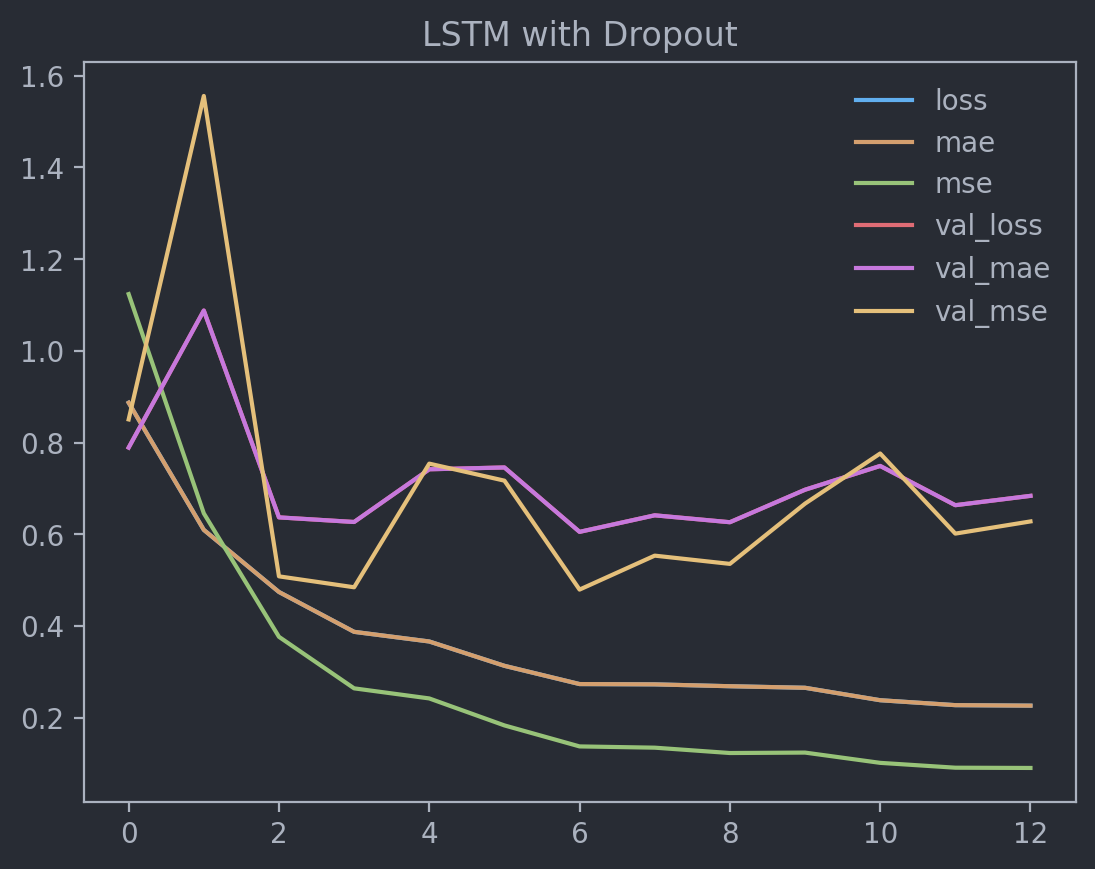

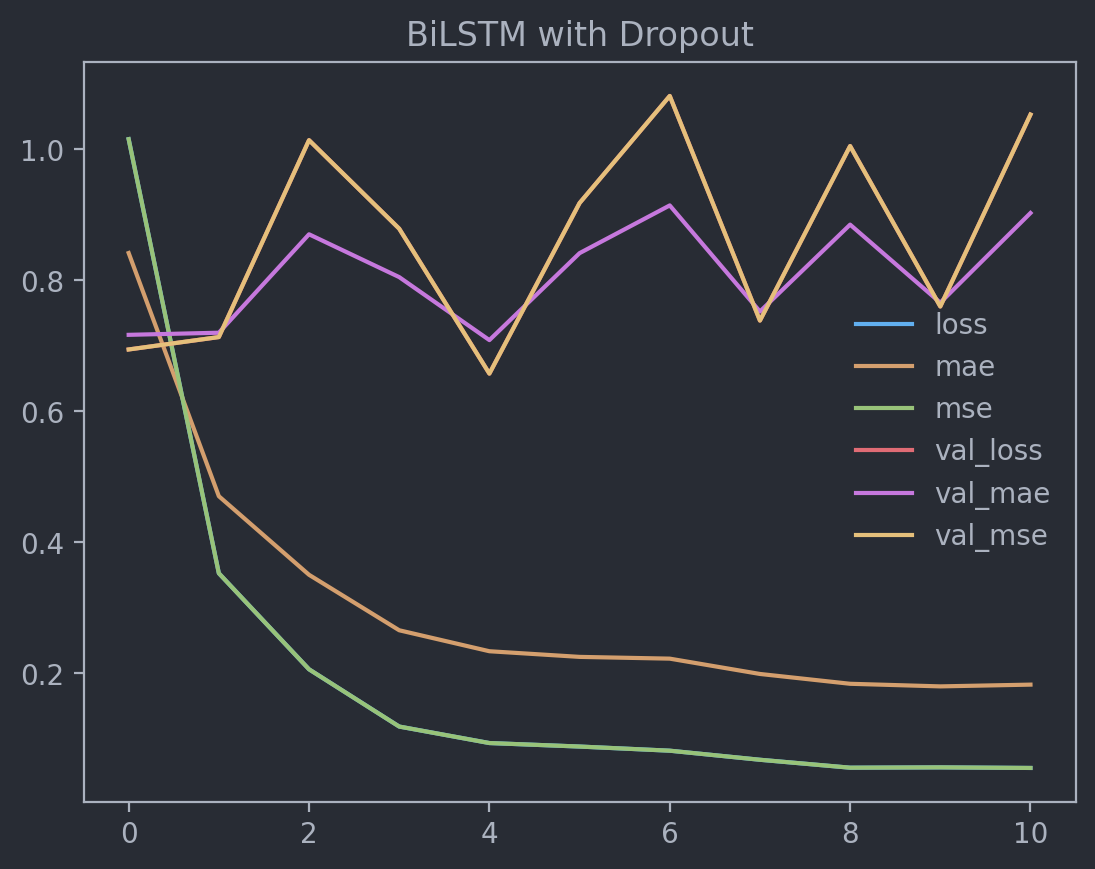

In [36]:
model_bilstm.history.model.summary()

# Plotting
plt.figure(figsize=(10, 5))
pd.DataFrame(history_lstm.history).plot(title='LSTM with Dropout')
pd.DataFrame(history_bilstm.history).plot(title='BiLSTM with Dropout')
pd.DataFrame(history_bilstm.history)

<Figure size 1200x800 with 0 Axes>

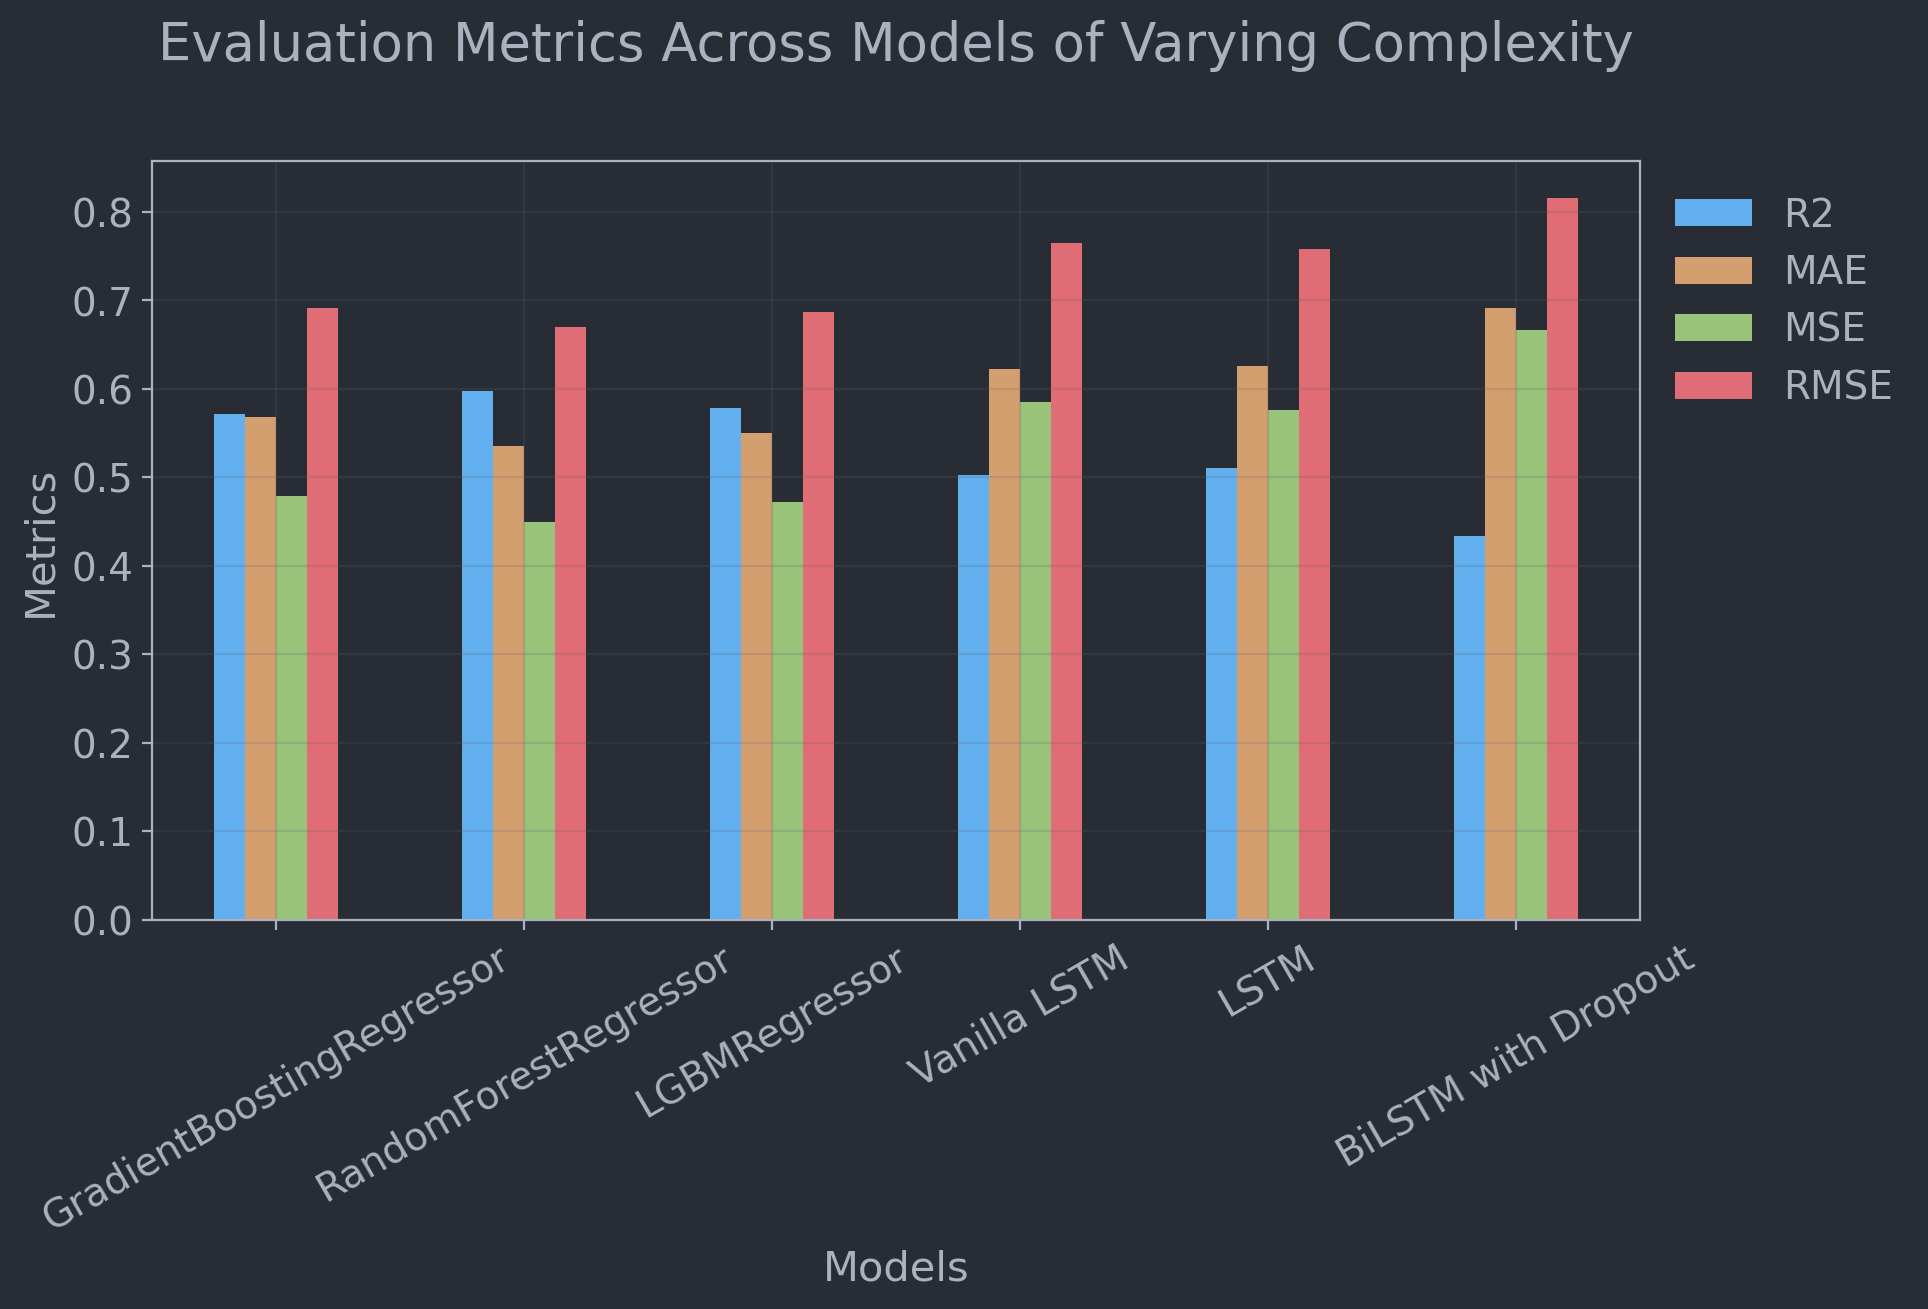

In [49]:
metric_results = df.copy()
# Create a larger figure
plt.figure(figsize=(12, 8))
model_results_df = pd.DataFrame(metric_results)
model_results_df.plot(kind='bar', figsize=(10, 7))

plt.title('Evaluation Metrics Across Models of Varying Complexity', fontsize=19, y=1.06, pad=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
legend = plt.legend(['R2', 'MAE', 'MSE', 'RMSE'], 
    loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

plt.xlabel('Models', fontsize=15)
plt.ylabel('Metrics', fontsize=15)

plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)

plt.tight_layout(pad=2)
plt.grid(alpha=.2)
plt.show()

,r2,mae,mse,rmse
GradientBoostingRegressor,0.571951,0.568649,0.478463,0.691710
RandomForestRegressor,0.598061,0.534904,0.449277,0.670282
LGBMRegressor,0.577930,0.549915,0.471780,0.686862
Vanilla LSTM,0.502838,0.623009,0.584724,0.764673
LSTM,0.510548,0.625488,0.575657,0.758721
BiLSTM with Dropout,0.433316,0.691959,0.666492,0.816389


<Figure size 1200x800 with 0 Axes>

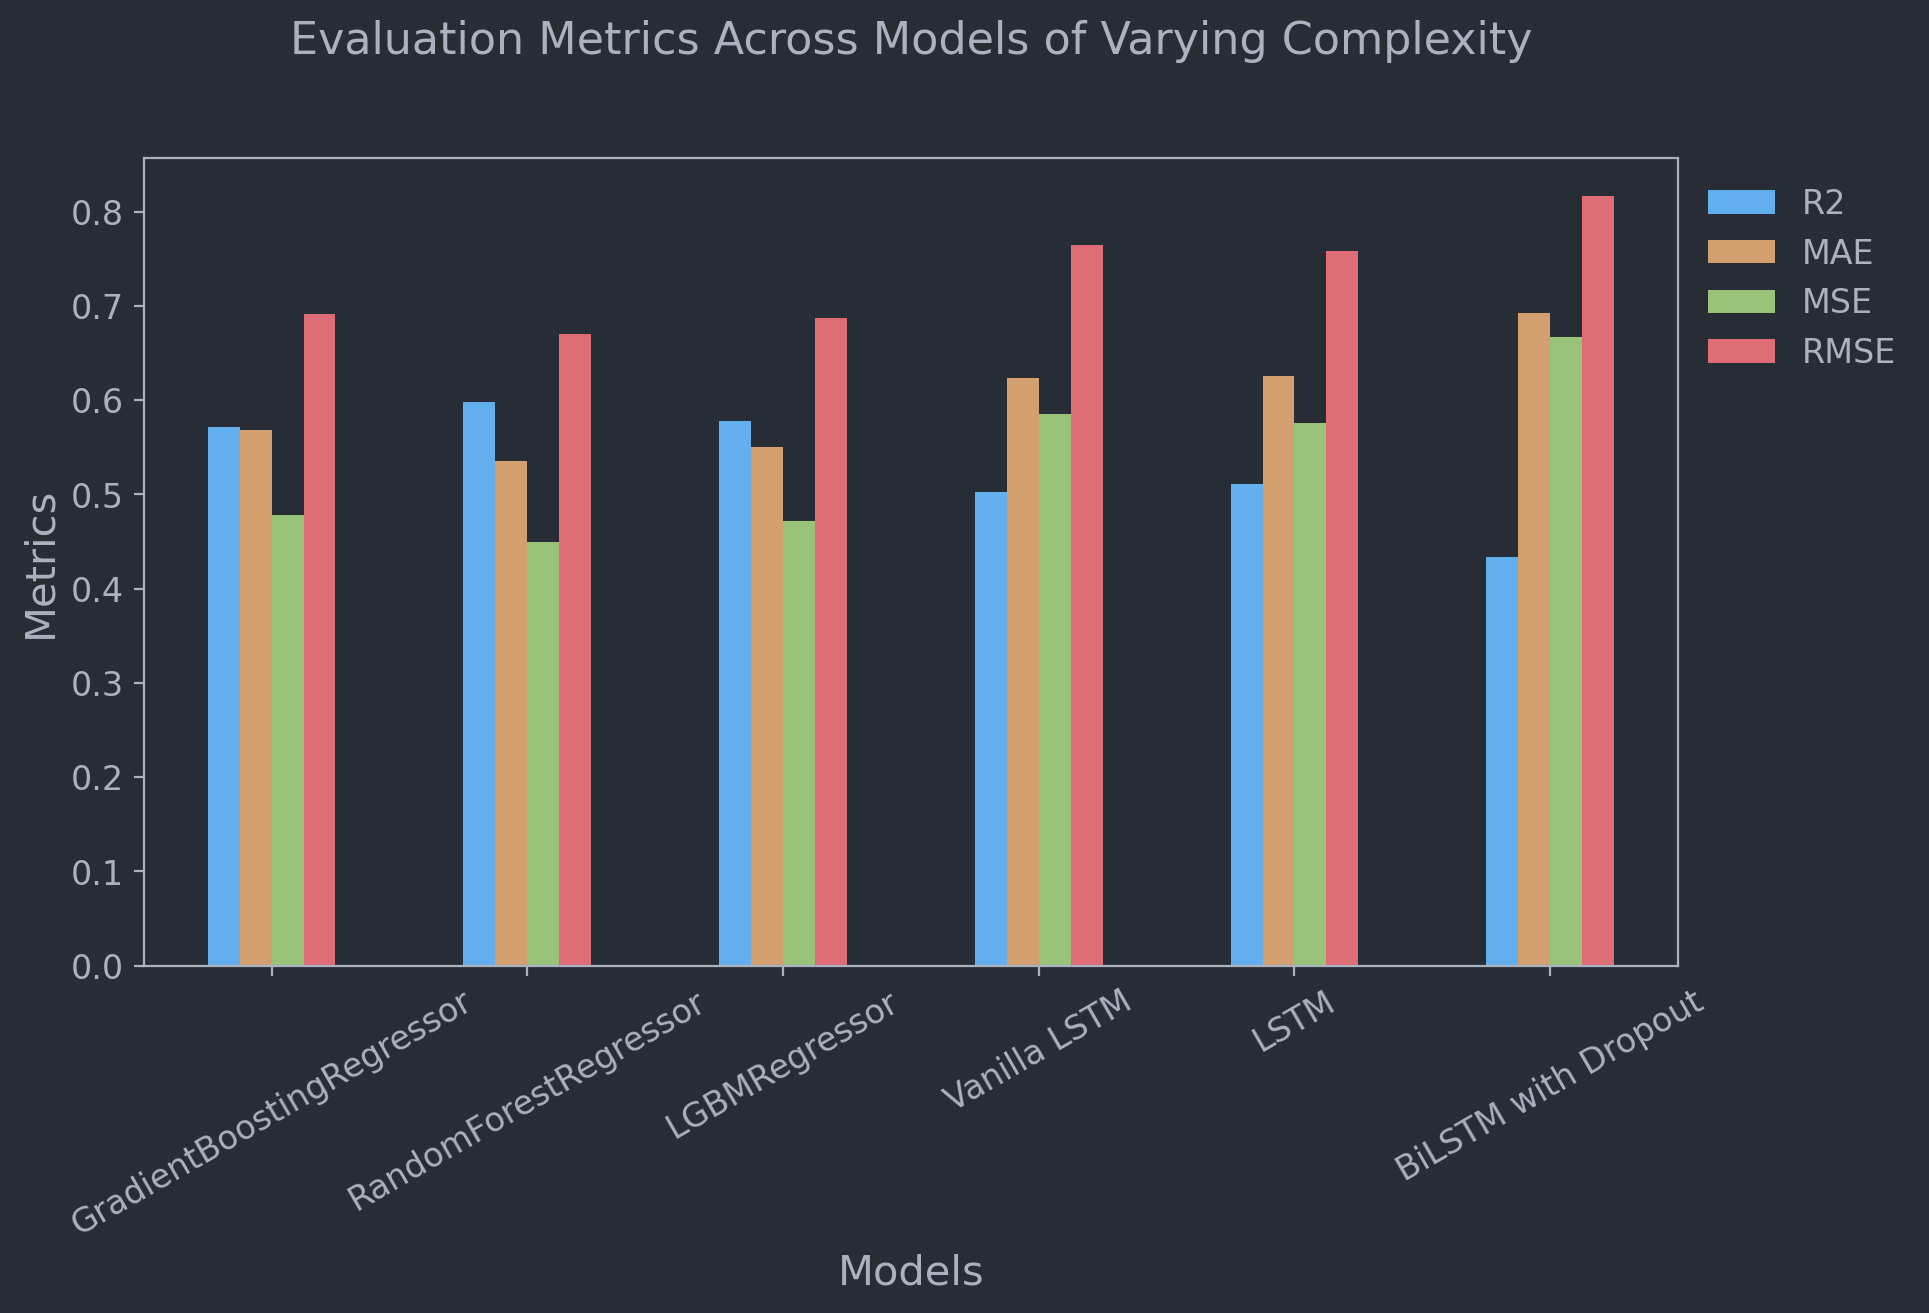

In [37]:
metric_results = {model_name: model_results[model_name]['metrics'] for model_name in model_results.keys() if 'metrics' in model_results[model_name]}
model_results_df = pd.DataFrame(metric_results).T[1:]

display(model_results_df)

metric_results = {model_name: model_results[model_name]['metrics'] for model_name in model_results.keys() if 'metrics' in model_results[model_name]}

# Create a larger figure
plt.figure(figsize=(12, 8))
model_results_df = pd.DataFrame(metric_results).T[1:]
model_results_df.plot(kind='bar', figsize=(10, 7))

plt.title('Evaluation Metrics Across Models of Varying Complexity', fontsize=16, y=1.06, pad=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)
legend = plt.legend(['R2', 'MAE', 'MSE', 'RMSE'], 
    loc='upper left', bbox_to_anchor=(1, 1), fontsize=14)

plt.xlabel('Models', fontsize=15)
plt.ylabel('Metrics', fontsize=15)

plt.xticks(fontsize=14, rotation=30)
plt.yticks(fontsize=14)

plt.tight_layout(pad=2)
plt.show()

## <a id='toc3_1_'></a>[hyper param tuning](#toc0_)

In [26]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from kerastuner import HyperModel, HyperParameters, RandomSearch


X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back

padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad training, validation and testing feature sets
X_train_padded = np.pad(X_train,  ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_val_padded = np.pad(X_val,  ((0, 0), (0, padding_val)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test,  ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape all sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))




class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        
        # LSTM layers
        for i in range(hp.Int('num_lstm_layers', min_value=1, max_value=3)):
            return_sequences = True if i < hp.Int('num_lstm_layers', min_value=1, max_value=3) - 1 else False
            units = hp.Int(f'lstm_{i}_units', min_value=50, max_value=200, step=50)
            model.add(LSTM(units, return_sequences=return_sequences, input_shape=self.input_shape))
            model.add(Dropout(hp.Float(f'lstm_{i}_dropout', min_value=0.1, max_value=0.5, step=0.1)))
        
        # Dense layers
        for i in range(hp.Int('num_dense_layers', min_value=1, max_value=2)):
            units = hp.Int(f'dense_{i}_units', min_value=50, max_value=200, step=50)
            model.add(Dense(units, activation='relu'))
        
        model.add(Dense(1, activation='linear'))
        
        # Compile the model
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])
        
        return model


hypermodel = LSTMHyperModel(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))


hp = HyperParameters()

# Create a tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    hyperparameters=hp,
    directory='tuner_results_v2',
    project_name='lstm_tuner'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# Perform the hyperparameter search
tuner.search(X_train_lstm, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

test_loss, test_mae, test_mse = best_model.evaluate(X_test_lstm, y_test)

Trial 100 Complete [00h 00m 29s]
val_loss: 0.6728130777676901

Best val_loss So Far: 0.5068688293298086
Total elapsed time: 00h 35m 38s
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8363 - mae: 0.8363 - mse: 0.9330  


In [35]:
import matplotlib.pyplot as plt

# Get the trials
trials = tuner.oracle.get_best_trials(num_trials=100)

trials[0].score

0.5068688293298086

### <a id='toc3_1_1_'></a>[Run with best over all pairs](#toc0_)

In [ ]:
pkl_pth = '/scratch/dan9232/trading-prj/Trading-Strategy-Project/examples/all_models_all_tickers.pkl'
import pickle
with open(pkl_pth, 'rb') as f:
    ticker_results = pickle.load(f)



MA_HIGH = 45
MA_LOW = 5
SPREAD_WINDOW = None
LOOK_BACK = 3



# Pair Selection
PAIR_IDX = 0

for PAIR_IDX in range(len(pairs)):

    try:

        model_results = {}
        
        ADD_SENTIMENT_MA = True

        pair = pairs[PAIR_IDX]
        print(pair)

        # Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
        pair_sentiment_df = pd.merge( data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"),)
        if ADD_SENTIMENT_MA:
            pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20, 40, 80], columns=pair_sentiment_df.columns)

        # Join Technical Indicators
        pair_ti_df = pd.merge( data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
        pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")


        # spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=SPREAD_WINDOW)
        # pair_df['spread'] = spread

        pair_df = pair_df[pair_df.index < '2024-01-01']
        # Calculate Moving Z score Calculation (Trading Signal)
        ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
        ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
        std_high = pair_df.spread.rolling(window=MA_HIGH).std()

        moving_zscore = (ma_low - ma_high) / std_high
        pair_df['zscore_spread'] = moving_zscore


        train_data, val_data, test_data = create_dataset(
            pair_df, 
            look_back=LOOK_BACK, 
            target_col="zscore_spread", 
            drop_cols=DROP_COLS
        )

        spread_full, beta = get_spread(
            train_data['Adj Close_S1'], 
            train_data['Adj Close_S2'],
            data['Adj Close_S1'],
            data['Adj Close_S2']
        )
    
    data['spread'] = spread_full

        X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)

        ticker_results[tuple(pair)]['Vanilla LSTM']['X_test_bkp'] = X_test
    except:
        pass

In [35]:
with open(pkl_pth, 'wb') as f:
    pickle.dump(ticker_results, f)

### Run All models over all pairs

In [ ]:
import tensorflow as tf

keras = tf.keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout, Flatten
from keras.models import Sequential, save_model, load_model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.optimizers import Adam


def train(model, X_train, y_train, X_test, y_test, model_results, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    model_results[model_name] = {
        'metrics': calculate_metrics(y_test, y_pred),
        # 'model': model,
        'data': (X_train, y_train, X_test, y_test),
        'y_pred': y_pred,
    }

    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(y_test.index, y_test, label="Actual")
        ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
        ax.legend()
        plt.show()


MA_HIGH = 45
MA_LOW = 5
SPREAD_WINDOW = None
LOOK_BACK = 3

# Pair Selection
PAIR_IDX = 0

for PAIR_IDX in range(len(pairs)):

    try:

        model_results = {}

        ADD_SENTIMENT_MA = True

        pair = pairs[PAIR_IDX]
        print(pair)

        # Join Sentiment and add Sentiment Moving Averages if ADD_SENTIMENT_MA is True
        pair_sentiment_df = pd.merge(
            data[pair[0]].sentiment,
            data[pair[1]].sentiment,
            left_index=True,
            right_index=True,
            suffixes=("_S1", "_S2"),
        )
        if ADD_SENTIMENT_MA:
            pair_sentiment_df = add_moving_averages(
                pair_sentiment_df, [5, 10, 20, 40, 80],
                columns=pair_sentiment_df.columns)

        # Join Technical Indicators
        pair_ti_df = pd.merge(data[pair[0]].ti,
                              data[pair[1]].ti,
                              left_index=True,
                              right_index=True,
                              suffixes=("_S1", "_S2"))
        pair_df = pd.merge(pair_ti_df,
                           pair_sentiment_df,
                           left_index=True,
                           right_index=True,
                           how="left")

        spread = get_spread(pair_df['Adj Close_S1'],
                            pair_df['Adj Close_S2'],
                            window=SPREAD_WINDOW)
        pair_df['spread'] = spread

        pair_df = pair_df[pair_df.index < '2024-01-01']
        # Calculate Moving Z score Calculation (Trading Signal)
        ma_high = pair_df.spread.rolling(window=MA_HIGH).mean()
        ma_low = pair_df.spread.rolling(window=MA_LOW).mean()
        std_high = pair_df.spread.rolling(window=MA_HIGH).std()

        moving_zscore = (ma_low - ma_high) / std_high
        pair_df['zscore_spread'] = moving_zscore

        train_data, val_data, test_data = create_dataset(
            pair_df,
            look_back=LOOK_BACK,
            target_col="zscore_spread",
            drop_cols=DROP_COLS)

        X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(
            train_data, val_data, test_data)

        base_models = [
            LinearRegression(),
            # KNeighborsRegressor(),
            GradientBoostingRegressor(random_state=42),
            RandomForestRegressor(n_estimators=100, random_state=42),
            LGBMRegressor(random_state=42, verbose=-1),
        ]

        X_test_regress = pd.concat([X_val, X_test])
        y_test_regress = pd.concat([y_val, y_test])

        for model in base_models:
            train(model,
                  X_train,
                  y_train,
                  X_test_regress,
                  y_test_regress,
                  model_results,
                  plot=False)

        # Scale the data
        from sklearn.preprocessing import StandardScaler

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        def calculate_padding(features, look_back):
            return (look_back - (features % look_back)) % look_back

        padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
        padding_val = calculate_padding(X_val.shape[1], LOOK_BACK)
        padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

        # Pad training, validation and testing feature sets
        X_train_padded = np.pad(X_train, ((0, 0), (0, padding_train)),
                                'constant',
                                constant_values=0)
        X_val_padded = np.pad(X_val, ((0, 0), (0, padding_val)),
                              'constant',
                              constant_values=0)
        X_test_padded = np.pad(X_test, ((0, 0), (0, padding_test)),
                               'constant',
                               constant_values=0)

        # Reshape all sets for LSTM
        X_train_lstm = X_train_padded.reshape(
            (X_train.shape[0], LOOK_BACK, -1))
        X_val_lstm = X_val_padded.reshape((X_val.shape[0], LOOK_BACK, -1))
        X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))

        from keras.callbacks import CSVLogger, ModelCheckpoint

        LR = 0.001
        EPOCHS = 100
        BATCH_SIZE = 16

        # CSVLogger callback
        lstm_csv_logger = CSVLogger('lstm_training.csv')
        bilstm_csv_logger = CSVLogger('bilstm_training.csv')

        # ModelCheckpoint callback
        model_checkpoint_lstm = ModelCheckpoint(
            'best_model_lstm.keras',
            # save_best_only=True,
            monitor='val_loss',
            mode='min')
        model_checkpoint_bilstm = ModelCheckpoint(
            'best_model_bilstm.keras',
            # save_best_only=True,
            monitor='val_loss',
            mode='min')

        # Build the LSTM model
        model_vanilla_lstm = Sequential([
            LSTM(50,
                 return_sequences=True,
                 input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
            LSTM(50),
            Dense(1)
        ])

        optimizer = Adam(learning_rate=LR)

        early_stopping = EarlyStopping(monitor='val_loss', patience=6)
        history_vanilla_lstm = History()

        model_vanilla_lstm.compile(optimizer=optimizer,
                                   loss='mae',
                                   metrics=['mae', 'mse'])

        # Fit the model
        model_vanilla_lstm.fit(
            X_train_lstm,
            y_train,
            epochs=EPOCHS,
            validation_data=(X_val_lstm, y_val),
            verbose=1,
            callbacks=[early_stopping, history_vanilla_lstm],
            batch_size=BATCH_SIZE)

        # Predict
        y_pred_vanilla_lstm = model_vanilla_lstm.predict(X_test_lstm)

        # Evaluate
        model_results['Vanilla LSTM'] = {
            'metrics': calculate_metrics(y_test,
                                         y_pred_vanilla_lstm.flatten()),
            # 'model': model_vanilla_lstm,
            'data': (X_train_lstm, y_train, X_test_lstm, y_test),
            'y_pred': y_pred_vanilla_lstm,
            'X_test_og': X_test,
        }

        model_lstm = Sequential([
            LSTM(100,
                 return_sequences=True,
                 input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
            Dropout(0.2),
            LSTM(100, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dropout(0.2),
            Dense(50, activation='relu'),
            Dense(1)
        ])
        model_lstm = Sequential([
            LSTM(200,
                 return_sequences=True,
                 input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
            Dropout(0.3),
            LSTM(200, return_sequences=True),
            Dropout(0.3),
            LSTM(100),
            Dropout(0.3),
            Dense(100, activation='relu'),
            Dense(1, activation='linear')
        ])

        # Adjusted model architecture
        model_lstm = Sequential([
            LSTM(150,
                 return_sequences=True,
                 input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
            Dropout(0.4),
            LSTM(150),
            Dropout(0.3),
            Dense(200, activation='relu'),
            Dense(1, activation='linear')
        ])

        # Optimizer configuration
        LR = 0.001
        optimizer = Adam(learning_rate=LR)

        # Compile the model
        model_lstm.compile(optimizer=optimizer,
                           loss='mae',
                           metrics=['mae', 'mse'])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=6)
        history_lstm = History()

        optimizer = Adam(learning_rate=LR)

        early_stopping = EarlyStopping(monitor='val_loss', patience=6)
        history_lstm = History()

        model_lstm.compile(
            optimizer=optimizer,
            loss='mae',
            metrics=['mae', 'mse'],
        )

        # Fit the model

        model_lstm.fit(
            X_train_lstm,
            y_train,
            epochs=EPOCHS,
            validation_data=(X_val_lstm, y_val),
            verbose=1,
            callbacks=[
                early_stopping, history_lstm, lstm_csv_logger,
                model_checkpoint_lstm
            ],
            batch_size=BATCH_SIZE,
        )
        model_lstm.history.history
        # Predict
        y_pred_lstm = model_lstm.predict(X_test_lstm)

        # Evaluate
        model_results['LSTM'] = {
            'metrics': calculate_metrics(y_test, y_pred_lstm.flatten()),
            # 'model': model_lstm,
            'data': (X_train_lstm, y_train, X_test_lstm, y_test),
            'y_pred': y_pred_lstm,
            'X_test_og': X_test,
        }

        # Build the Bidirectional LSTM model
        model_bilstm = Sequential([
            Bidirectional(LSTM(50, return_sequences=True),
                          input_shape=(X_train_lstm.shape[1],
                                       X_train_lstm.shape[2])),
            Dropout(0.2),
            Bidirectional(LSTM(50)),
            Dropout(0.2),
            Dense(1)
        ])
        from keras.layers import TimeDistributed

        # Build the Bidirectional LSTM model
        model_bilstm = Sequential([
            Bidirectional(LSTM(100, return_sequences=True),
                          input_shape=(X_train_lstm.shape[1],
                                       X_train_lstm.shape[2])),
            Dropout(0.2),
            Bidirectional(LSTM(100, return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(50)),
            Dropout(0.2),
            Dense(50,
                  activation='relu'),  # Add a dense layer for more complexity
            Dense(1)
        ])

        optimizer = Adam(learning_rate=LR)

        early_stopping = EarlyStopping(monitor='val_loss', patience=6)
        history_bilstm = History()
        model_bilstm.compile(optimizer=optimizer,
                             loss='mae',
                             metrics=['mae', 'mse'])

        # Fit the model
        model_bilstm.fit(
            X_train_lstm,
            y_train,
            epochs=EPOCHS,
            validation_data=(X_val_lstm, y_val),
            verbose=1,
            callbacks=[
                early_stopping, history_bilstm, bilstm_csv_logger,
                model_checkpoint_bilstm
            ],
            batch_size=BATCH_SIZE,
        )

        model_bilstm.history.history
        # Predict
        y_pred_bilstm = model_bilstm.predict(X_test_lstm)

        # Evaluate
        model_results['BiLSTM with Dropout'] = {
            'metrics': calculate_metrics(y_test, y_pred_bilstm.flatten()),
            # 'model': model_bilstm,
            'data': (X_train_lstm, y_train, X_test_lstm, y_test),
            'X_test_og': X_test,
            'y_pred': y_pred_bilstm
        }

        ticker_results[tuple(pair)] = model_results

    except:
        print("Issue with ticker", pair)


In [57]:
ticker_results
import pickle
with open('all_models_all_tickers.pkl', 'wb') as f:
    pickle.dump(ticker_results, f)